In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import TextVectorization
import re,string
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,LayerNormalization

In [2]:
# Load the dataset
df = pd.read_excel("Allergy.xlsx",header=0)

In [3]:
# Set display options to show full content without truncation
pd.set_option('display.max_colwidth', None)
NewData = df[['Patient','Doctor']]

In [4]:
print(f'Dataframe size: {len(NewData)}')
NewData.head(20)

Dataframe size: 268


,Patient,Doctor
0,"Doctor, I've been feeling really strange lately. I had a reaction after eating something, and my throat felt like it was closing up. I'm really worried. Can you help me?","Of course, I'll do my best to help you. It sounds like you may have experienced an allergic reaction. Can you tell me more about what happened?"
1,"Well, I was at a restaurant and I had this dish with shrimp. Shortly after I finished eating, my lips started to swell, and I had difficulty breathing. I've never had this happen before, and it scared me.","I understand your concern. Based on your symptoms, it's possible that you had a severe allergic reaction called anaphylaxis. This is a serious condition that requires immediate medical attention. Have you experienced any other symptoms, such as hives, itching, or lightheadedness?"
2,"Yes, actually, I did notice some hives on my arms and chest, and I felt lightheaded and dizzy. I had no idea this could happen from eating shrimp. What exactly is anaphylaxis?","That's probably what's causing your reaction. Pork is a common allergen, and it can cause a variety of symptoms, including hives, difficulty breathing, and even anaphylaxis."
3,"Anaphylaxis is a severe allergic reaction that can occur within minutes or even seconds after exposure to an allergen, such as shrimp in your case. It can affect multiple systems in your body and can be life-threatening if not treated promptly. Common symptoms include swelling of the lips, face, or throat, difficulty breathing, hives or rash, and a drop in blood pressure leading to dizziness or fainting.",That sounds really serious! I had no idea an allergic reaction could be so dangerous. What should I do if it happens again?
4,"Good morning, Doctor. I've been experiencing some unusual symptoms, and I'm not sure what's going on. I noticed some skin issues and recently had a blood test done. Can you please take a look at the reports and help me understand what's happening?","Good morning. Of course, I'll be happy to assist you. Please hand me your reports, and let's discuss your symptoms in detail. What specific skin issues have you been experiencing?"
5,"Well, I've been having frequent rashes and hives on different parts of my body. They appear as red, itchy patches, and they come and go randomly. It's quite uncomfortable, and I'm not sure what triggers them.","I see. Skin rashes and hives can be indicative of an allergic reaction. It's important to identify the underlying cause. Now, let's take a look at your blood test results. Could you please pass them to me?"
6,"Here are the reports, Doctor. I hope they can provide some insight into my condition.",Thank you. Let me review these reports.
7,"Doctor, I had a really scary experience after eating pork yesterday. My face swelled up, and I had difficulty breathing. I think it might have been an allergic reaction. Can you help me understand what happened?",I'm sorry to hear about your distressing experience. Allergic reactions can indeed occur after consuming certain foods. Let's discuss your symptoms in more detail. Did you notice any other reactions apart from the facial swelling and difficulty breathing?
8,"Yes, I also had hives on my body, and I felt quite dizzy. It was really frightening, and I had no idea that this could happen from eating pork. Is it possible that I have an allergy to pork?","It's possible that you have developed an allergy to pork. Allergic reactions can vary from person to person, and some individuals can be allergic to specific types of meat. To better understand your condition, it would be helpful to review your skin and blood test reports. Can you please provide me with those?"
9,"Certainly, Doctor. Here are the reports. I hope they can shed some light on what's happening.","Thank you. Let me take a look at the report .Based on your blood test results, your IgE levels are elevated, indicating a possible allergic reaction. Additionally, your skin prick test shows a positive reaction to p

In [5]:
NewData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Patient  246 non-null    object
 1   Doctor   258 non-null    object
dtypes: object(2)
memory usage: 4.3+ KB


C:\Users\Nuwanga Wijamuni\AppData\Local\Temp\ipykernel_21064\1690811942.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NewData['question Tokens'] = NewData['Patient'].apply(lambda x: len(str(x).split()))


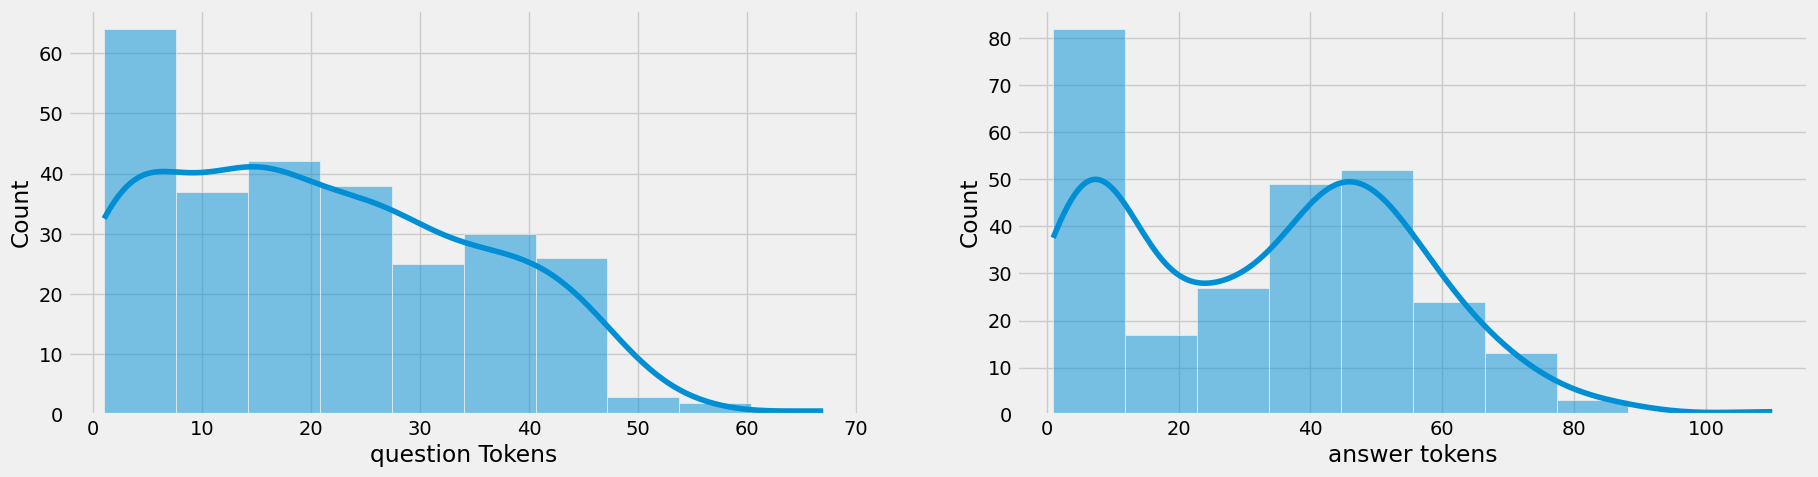

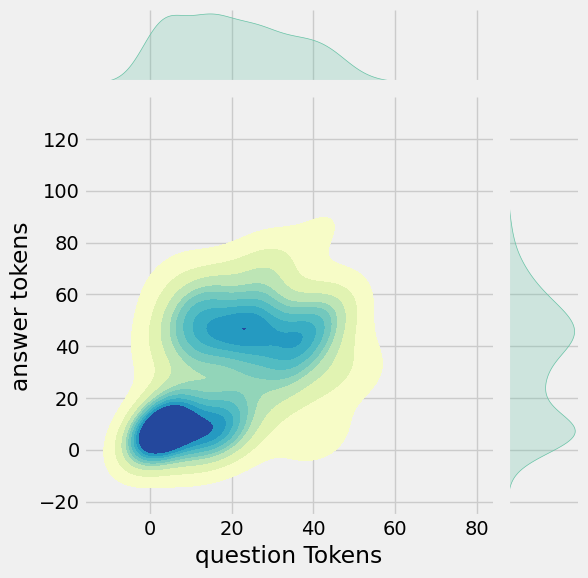

In [6]:
NewData['question Tokens'] = NewData['Patient'].apply(lambda x: len(str(x).split()))
NewData['answer tokens'] = NewData['Doctor'].apply(lambda x: len(str(x).split()))
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
sns.set_palette('Set2')

sns.histplot(x=NewData['question Tokens'], data=NewData, kde=True, ax=ax[0])
sns.histplot(x=NewData['answer tokens'], data=NewData, kde=True, ax=ax[1])
sns.jointplot(x='question Tokens', y='answer tokens', data=NewData, kind='kde', fill=True, cmap='YlGnBu')

plt.show()
plt.show()

In [7]:

def clean_text(text):
    text=re.sub('-',' ',text.lower())
    text=re.sub('[.]',' . ',text)
    text=re.sub('[1]',' 1 ',text)
    text=re.sub('[2]',' 2 ',text)
    text=re.sub('[3]',' 3 ',text)
    text=re.sub('[4]',' 4 ',text)
    text=re.sub('[5]',' 5 ',text)
    text=re.sub('[6]',' 6 ',text)
    text=re.sub('[7]',' 7 ',text)
    text=re.sub('[8]',' 8 ',text)
    text=re.sub('[9]',' 9 ',text)
    text=re.sub('[0]',' 0 ',text)
    text=re.sub('[,]',' , ',text)
    text=re.sub('[?]',' ? ',text)
    text=re.sub('[!]',' ! ',text)
    text=re.sub('[$]',' $ ',text)
    text=re.sub('[&]',' & ',text)
    text=re.sub('[/]',' / ',text)
    text=re.sub('[:]',' : ',text)
    text=re.sub('[;]',' ; ',text)
    text=re.sub('[*]',' * ',text)
    text=re.sub('[\']',' \' ',text)
    text=re.sub('[\"]',' \" ',text)
    text=re.sub('\t',' ',text)
    return text

In [8]:
NewData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Patient          246 non-null    object
 1   Doctor           258 non-null    object
 2   question Tokens  268 non-null    int64 
 3   answer tokens    268 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 8.5+ KB


In [9]:
NewData.drop(columns=['answer tokens', 'question Tokens'], inplace=True)
NewData['encoder_inputs'] = NewData['Patient'].astype(str).apply(clean_text)
NewData['decoder_targets'] = NewData['Doctor'].apply(lambda x: clean_text(x) if pd.notnull(x) else '')
NewData['decoder_targets'] += ' <end>'
NewData['decoder_inputs'] = '<start> ' + NewData['Doctor'].apply(lambda x: clean_text(x) if pd.notnull(x) else '')
NewData['decoder_inputs'] += ' <end>'
NewData.head(10)

,Patient,Doctor,encoder_inputs,decoder_targets,decoder_inputs
0,"Doctor, I've been feeling really strange lately. I had a reaction after eating something, and my throat felt like it was closing up. I'm really worried. Can you help me?","Of course, I'll do my best to help you. It sounds like you may have experienced an allergic reaction. Can you tell me more about what happened?","doctor , i ' ve been feeling really strange lately . i had a reaction after eating something , and my throat felt like it was closing up . i ' m really worried . can you help me ?","of course , i ' ll do my best to help you . it sounds like you may have experienced an allergic reaction . can you tell me more about what happened ? <end>","<start> of course , i ' ll do my best to help you . it sounds like you may have experienced an allergic reaction . can you tell me more about what happened ? <end>"
1,"Well, I was at a restaurant and I had this dish with shrimp. Shortly after I finished eating, my lips started to swell, and I had difficulty breathing. I've never had this happen before, and it scared me.","I understand your concern. Based on your symptoms, it's possible that you had a severe allergic reaction called anaphylaxis. This is a serious condition that requires immediate medical attention. Have you experienced any other symptoms, such as hives, itching, or lightheadedness?","well , i was at a restaurant and i had this dish with shrimp . shortly after i finished eating , my lips started to swell , and i had difficulty breathing . i ' ve never had this happen before , and it scared me .","i understand your concern . based on your symptoms , it ' s possible that you had a severe allergic reaction called anaphylaxis . this is a serious condition that requires immediate medical attention . have you experienced any other symptoms , such as hives , itching , or lightheadedness ? <end>","<start> i understand your concern . based on your symptoms , it ' s possible that you had a severe allergic reaction called anaphylaxis . this is a serious condition that requires immediate medical attention . have you experienced any other symptoms , such as hives , itching , or lightheadedness ? <end>"
2,"Yes, actually, I did notice some hives on my arms and chest, and I felt lightheaded and dizzy. I had no idea this could happen from eating shrimp. What exactly is anaphylaxis?","That's probably what's causing your reaction. Pork is a common allergen, and it can cause a variety of symptoms, including hives, difficulty breathing, and even anaphylaxis.","yes , actually , i did notice some hives on my arms and chest , and i felt lightheaded and dizzy . i had no idea this could happen from eating shrimp . what exactly is anaphylaxis ?","that ' s probably what ' s causing your reaction . pork is a common allergen , and it can cause a variety of symptoms , including hives , difficulty breathing , and even anaphylaxis . <end>","<start> that ' s probably what ' s causing your reaction . pork is a common allergen , and it can cause a variety of symptoms , including hives , difficulty breathing , and even anaphylaxis . <end>"
3,"Anaphylaxis is a severe allergic reaction that can occur within minutes or even seconds after exposure to an allergen, such as shrimp in your case. It can affect multiple systems in your body and can be life-threatening if not treated promptly. Common symptoms include swelling of the lips, face, or throat, difficulty breathing, hives or rash, and a drop in blood pressure leading to dizziness or fainting.",That sounds really serious! I had no idea an allergic reaction could be so dangerous. What should I do if it happens again?,"anaphylaxis is a severe allergic reaction that can occur within minutes or even seconds after exposure to an allergen , such as shrimp in your case . it can affect multiple systems in your body and can be life threatening if not treated promptly . common symptoms include swelling of the lips , face , or throat , difficulty brea

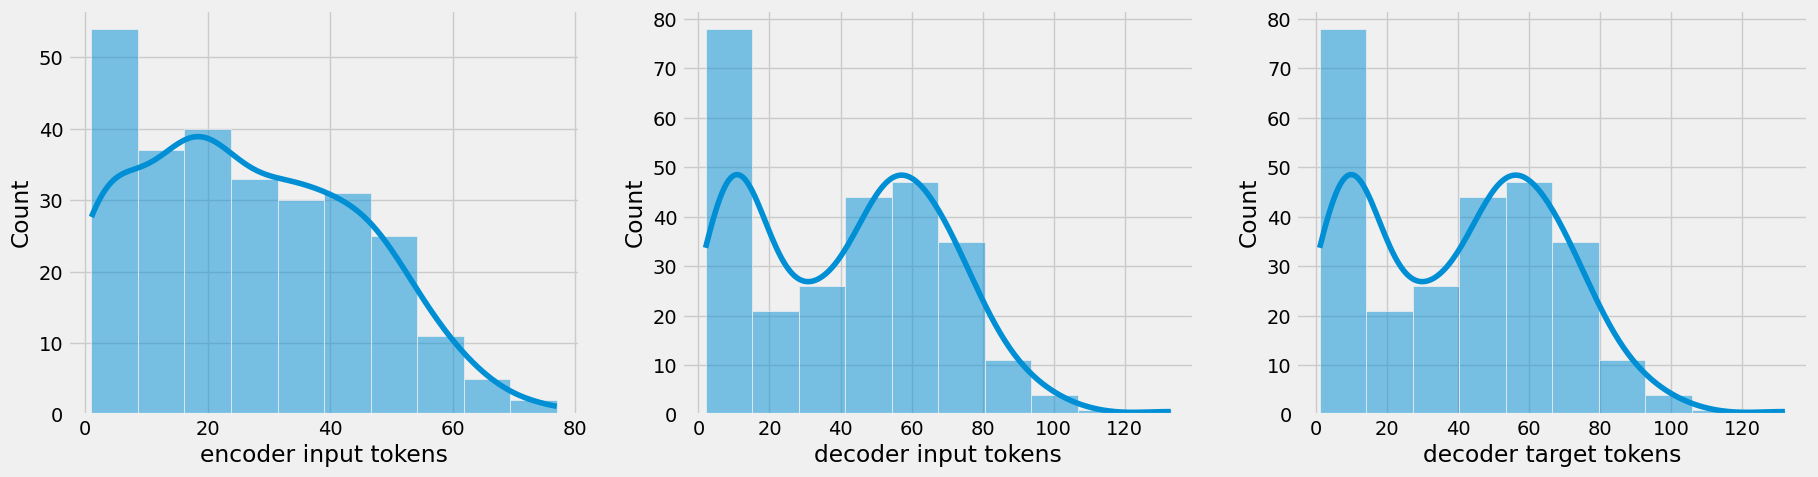

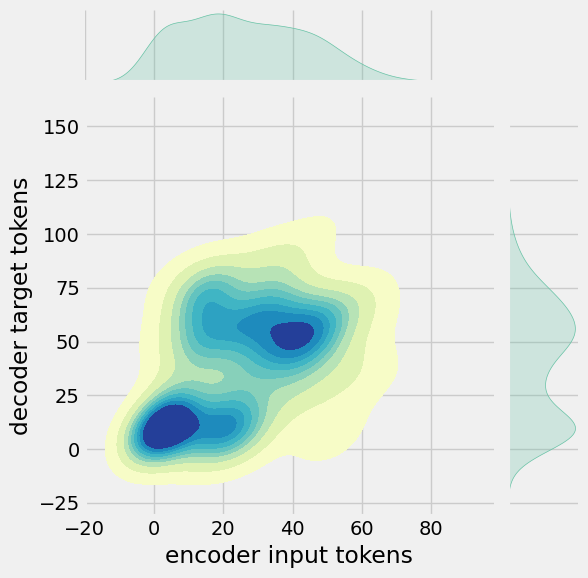

In [10]:
NewData['encoder input tokens']=NewData['encoder_inputs'].apply(lambda x:len(x.split()))
NewData['decoder input tokens']=NewData['decoder_inputs'].apply(lambda x:len(x.split()))
NewData['decoder target tokens']=NewData['decoder_targets'].apply(lambda x:len(x.split()))
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
sns.set_palette('Set2')
sns.histplot(x=NewData['encoder input tokens'],data=NewData,kde=True,ax=ax[0])
sns.histplot(x=NewData['decoder input tokens'],data=NewData,kde=True,ax=ax[1])
sns.histplot(x=NewData['decoder target tokens'],data=NewData,kde=True,ax=ax[2])
sns.jointplot(x='encoder input tokens',y='decoder target tokens',data=NewData,kind='kde',fill=True,cmap='YlGnBu')
plt.show()

In [11]:
max_encoder_input_row = NewData['encoder_inputs'].str.split().str.len().argmax()
max_encoder_input = NewData.loc[max_encoder_input_row, 'encoder_inputs']

print(f"After preprocessing: {' '.join(max_encoder_input.split())}")
print(f"Max encoder input length: {NewData['encoder_inputs'].str.split().str.len().max()}")
print(f"Max decoder input length: {NewData['decoder_inputs'].str.split().str.len().max()}")
print(f"Max decoder target length: {NewData['decoder_targets'].str.split().str.len().max()}")

After preprocessing: anaphylaxis is a severe allergic reaction that can occur within minutes or even seconds after exposure to an allergen , such as shrimp in your case . it can affect multiple systems in your body and can be life threatening if not treated promptly . common symptoms include swelling of the lips , face , or throat , difficulty breathing , hives or rash , and a drop in blood pressure leading to dizziness or fainting .
Max encoder input length: 77
Max decoder input length: 133
Max decoder target length: 132


In [12]:
NewData.head()

,Patient,Doctor,encoder_inputs,decoder_targets,decoder_inputs,encoder input tokens,decoder input tokens,decoder target tokens
0,"Doctor, I've been feeling really strange lately. I had a reaction after eating something, and my throat felt like it was closing up. I'm really worried. Can you help me?","Of course, I'll do my best to help you. It sounds like you may have experienced an allergic reaction. Can you tell me more about what happened?","doctor , i ' ve been feeling really strange lately . i had a reaction after eating something , and my throat felt like it was closing up . i ' m really worried . can you help me ?","of course , i ' ll do my best to help you . it sounds like you may have experienced an allergic reaction . can you tell me more about what happened ? <end>","<start> of course , i ' ll do my best to help you . it sounds like you may have experienced an allergic reaction . can you tell me more about what happened ? <end>",40,35,34
1,"Well, I was at a restaurant and I had this dish with shrimp. Shortly after I finished eating, my lips started to swell, and I had difficulty breathing. I've never had this happen before, and it scared me.","I understand your concern. Based on your symptoms, it's possible that you had a severe allergic reaction called anaphylaxis. This is a serious condition that requires immediate medical attention. Have you experienced any other symptoms, such as hives, itching, or lightheadedness?","well , i was at a restaurant and i had this dish with shrimp . shortly after i finished eating , my lips started to swell , and i had difficulty breathing . i ' ve never had this happen before , and it scared me .","i understand your concern . based on your symptoms , it ' s possible that you had a severe allergic reaction called anaphylaxis . this is a serious condition that requires immediate medical attention . have you experienced any other symptoms , such as hives , itching , or lightheadedness ? <end>","<start> i understand your concern . based on your symptoms , it ' s possible that you had a severe allergic reaction called anaphylaxis . this is a serious condition that requires immediate medical attention . have you experienced any other symptoms , such as hives , itching , or lightheadedness ? <end>",47,53,52
2,"Yes, actually, I did notice some hives on my arms and chest, and I felt lightheaded and dizzy. I had no idea this could happen from eating shrimp. What exactly is anaphylaxis?","That's probably what's causing your reaction. Pork is a common allergen, and it can cause a variety of symptoms, including hives, difficulty breathing, and even anaphylaxis.","yes , actually , i did notice some hives on my arms and chest , and i felt lightheaded and dizzy . i had no idea this could happen from eating shrimp . what exactly is anaphylaxis ?","that ' s probably what ' s causing your reaction . pork is a common allergen , and it can cause a variety of symptoms , including hives , difficulty breathing , and even anaphylaxis . <end>","<start> that ' s probably what ' s causing your reaction . pork is a common allergen , and it can cause a variety of symptoms , including hives , difficulty breathing , and even anaphylaxis . <end>",38,38,37
3,"Anaphylaxis is a severe allergic reaction that can occur within minutes or even seconds after exposure to an allergen, such as shrimp in your case. It can affect multiple systems in your body and can be life-threatening if not treated promptly. Common symptoms include swelling of the lips, face, or throat, difficulty breathing, hives or rash, and a drop in blood pressure leading to dizziness or fainting.",That sounds really serious! I had no idea an allergic reaction could be so dangerous. What should I do if it happens again?,"anaphylaxis is a severe allergic reaction that can occur within minutes or even seconds after exposure to an allergen , such as shrimp in your case . it can affect multiple systems in your body and can be life threatening if not treated p

In [13]:
NewData.drop(columns=['Patient','Doctor','encoder input tokens','decoder input tokens','decoder target tokens'],axis=1,inplace=True)
params={
    "vocab_size":2500,
    "max_sequence_length":40,
    "learning_rate":0.008,
    "batch_size":149,
    "lstm_cells":256,
    "embedding_dim":256,
    "buffer_size":10000
}

In [14]:
learning_rate=params['learning_rate']
batch_size=params['batch_size']
embedding_dim=params['embedding_dim']
lstm_cells=params['lstm_cells']
vocab_size=params['vocab_size']
buffer_size=params['buffer_size']
max_sequence_length=params['max_sequence_length']
NewData.head(10)

,encoder_inputs,decoder_targets,decoder_inputs
0,"doctor , i ' ve been feeling really strange lately . i had a reaction after eating something , and my throat felt like it was closing up . i ' m really worried . can you help me ?","of course , i ' ll do my best to help you . it sounds like you may have experienced an allergic reaction . can you tell me more about what happened ? <end>","<start> of course , i ' ll do my best to help you . it sounds like you may have experienced an allergic reaction . can you tell me more about what happened ? <end>"
1,"well , i was at a restaurant and i had this dish with shrimp . shortly after i finished eating , my lips started to swell , and i had difficulty breathing . i ' ve never had this happen before , and it scared me .","i understand your concern . based on your symptoms , it ' s possible that you had a severe allergic reaction called anaphylaxis . this is a serious condition that requires immediate medical attention . have you experienced any other symptoms , such as hives , itching , or lightheadedness ? <end>","<start> i understand your concern . based on your symptoms , it ' s possible that you had a severe allergic reaction called anaphylaxis . this is a serious condition that requires immediate medical attention . have you experienced any other symptoms , such as hives , itching , or lightheadedness ? <end>"
2,"yes , actually , i did notice some hives on my arms and chest , and i felt lightheaded and dizzy . i had no idea this could happen from eating shrimp . what exactly is anaphylaxis ?","that ' s probably what ' s causing your reaction . pork is a common allergen , and it can cause a variety of symptoms , including hives , difficulty breathing , and even anaphylaxis . <end>","<start> that ' s probably what ' s causing your reaction . pork is a common allergen , and it can cause a variety of symptoms , including hives , difficulty breathing , and even anaphylaxis . <end>"
3,"anaphylaxis is a severe allergic reaction that can occur within minutes or even seconds after exposure to an allergen , such as shrimp in your case . it can affect multiple systems in your body and can be life threatening if not treated promptly . common symptoms include swelling of the lips , face , or throat , difficulty breathing , hives or rash , and a drop in blood pressure leading to dizziness or fainting .",that sounds really serious ! i had no idea an allergic reaction could be so dangerous . what should i do if it happens again ? <end>,<start> that sounds really serious ! i had no idea an allergic reaction could be so dangerous . what should i do if it happens again ? <end>
4,"good morning , doctor . i ' ve been experiencing some unusual symptoms , and i ' m not sure what ' s going on . i noticed some skin issues and recently had a blood test done . can you please take a look at the reports and help me understand what ' s happening ?","good morning . of course , i ' ll be happy to assist you . please hand me your reports , and let ' s discuss your symptoms in detail . what specific skin issues have you been experiencing ? <end>","<start> good morning . of course , i ' ll be happy to assist you . please hand me your reports , and let ' s discuss your symptoms in detail . what specific skin issues have you been experiencing ? <end>"
5,"well , i ' ve been having frequent rashes and hives on different parts of my body . they appear as red , itchy patches , and they come and go randomly . it ' s quite uncomfortable , and i ' m not sure what triggers them .","i see . skin rashes and hives can be indicative of an allergic reaction . it ' s important to identify the underlying cause . now , let ' s take a look at your blood test results . could you please pass them to me ? <end>","<start> i see . skin rashes and hives can be indicative of an allergic reaction . it ' s important to identify the underlying cause . now , let ' s take a look at your blood test results . could you please pass them to me ? <en

In [15]:
vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    standardize=None,
    output_mode='int',
    output_sequence_length=max_sequence_length
)
vectorize_layer.adapt(NewData['encoder_inputs'] + ' ' + NewData['decoder_targets'] + ' <start> <end>')
vocab_size = len(vectorize_layer.get_vocabulary())
print(f'Vocab size: {vocab_size}')
print(f'{vectorize_layer.get_vocabulary()[:12]}')

Vocab size: 1016
['', '[UNK]', '.', ',', 'i', "'", '<end>', 'to', 'you', 'and', 'the', 'it']


In [16]:
def sequences2ids(sequence):
    return vectorize_layer(sequence)

def ids2sequences(ids):
    decode=''
    if type(ids)==int:
        ids=[ids]
    for id in ids:
        decode+=vectorize_layer.get_vocabulary()[id]+' '
    return decode

x = sequences2ids(NewData['encoder_inputs'])
yd = sequences2ids(NewData['decoder_inputs'])
y = sequences2ids(NewData['decoder_targets'])

print(f'Thank you. Let me examine your skin and review the reports.')
print(f'Question to tokens: {sequences2ids("Thank you. Let me examine your skin and review the reports.")[:10]}')
print(f'Encoder input shape: {x.shape}')
print(f'Decoder input shape: {yd.shape}')
print(f'Decoder target shape: {y.shape}')

Thank you. Let me examine your skin and review the reports.
Question to tokens: [  1   1   1  35  88  16  34   9 201  10]
Encoder input shape: (268, 40)
Decoder input shape: (268, 40)
Decoder target shape: (268, 40)


In [17]:
print(f'Encoder input: {x[0][:12]} ...')
print(f'Decoder input: {yd[0][:12]} ...')    # shifted by one time step of the target as input to decoder is the output of the previous timestep
print(f'Decoder target: {y[0][:12]} ...')

Encoder input: [ 33   3   4   5  41  62  93  64 482 313   2   4] ...
Decoder input: [ 13  23 258   3   4   5  50 106  24 180   7  52] ...
Decoder target: [ 23 258   3   4   5  50 106  24 180   7  52   8] ...


In [18]:
data=tf.data.Dataset.from_tensor_slices((x,yd,y))
data=data.shuffle(buffer_size)

train_data=data.take(int(.9*len(data)))
train_data=train_data.cache()
train_data=train_data.shuffle(buffer_size)
train_data=train_data.batch(batch_size)
train_data=train_data.prefetch(tf.data.AUTOTUNE)
train_data_iterator=train_data.as_numpy_iterator()

val_data=data.skip(int(.9*len(data))).take(int(.1*len(data)))
val_data=val_data.batch(batch_size)
val_data=val_data.prefetch(tf.data.AUTOTUNE)

_=train_data_iterator.next()
print(f'Number of train batches: {len(train_data)}')
print(f'Number of training data: {len(train_data)*batch_size}')
print(f'Number of validation batches: {len(val_data)}')
print(f'Number of validation data: {len(val_data)*batch_size}')
print(f'Encoder Input shape (with batches): {_[0].shape}')
print(f'Decoder Input shape (with batches): {_[1].shape}')
print(f'Target Output shape (with batches): {_[2].shape}')

Number of train batches: 2
Number of training data: 298
Number of validation batches: 1
Number of validation data: 149
Encoder Input shape (with batches): (149, 40)
Decoder Input shape (with batches): (149, 40)
Target Output shape (with batches): (149, 40)


In [40]:
class Encoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.vocab_size=vocab_size
        self.embedding_dim=embedding_dim
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='encoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.GlorotNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='encoder_lstm',
            kernel_initializer=tf.keras.initializers.GlorotNormal()
        )
    
    def call(self,encoder_inputs):
        self.inputs=encoder_inputs
        x=self.embedding(encoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        encoder_outputs,encoder_state_h,encoder_state_c=self.lstm(x)
        self.outputs=[encoder_state_h,encoder_state_c]
        return encoder_state_h,encoder_state_c

encoder=Encoder(lstm_cells,embedding_dim,vocab_size,name='encoder')
encoder.call(_[0])

(<tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[ 0.02763438,  0.17581291,  0.21416582, ...,  0.15758248,
          0.01357438, -0.00800343],
        [ 0.09366734, -0.03548377,  0.21240135, ..., -0.00178594,
          0.01262595, -0.00261095],
        [ 0.16593142,  0.08599135, -0.1405205 , ...,  0.18889652,
         -0.03188433, -0.11899646],
        ...,
        [ 0.4362614 , -0.11363763,  0.01882041, ...,  0.14676172,
         -0.02148326, -0.22691283],
        [-0.02898508,  0.16224422,  0.22006601, ...,  0.13462777,
         -0.00578193,  0.02416164],
        [ 0.07149186,  0.00067548, -0.05293309, ..., -0.07380644,
          0.09334129,  0.18951051]], dtype=float32)>,
 <tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[ 0.05473319,  0.38045755,  0.5586896 , ...,  0.27984348,
          0.02190259, -0.01726447],
        [ 0.19949506, -0.07022026,  0.57501554, ..., -0.00319058,
          0.01911169, -0.00632811],
        [ 0.23731947,  0.1710991 , -0.31228593,

In [41]:
class Decoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.embedding_dim=embedding_dim
        self.vocab_size=vocab_size
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='decoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.HeNormal()
        )
        self.normalize1=LayerNormalization()  # Added new normalization layer here
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='decoder_lstm',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
        self.normalize2=LayerNormalization()  # Renamed old normalization layer
        self.fc=Dense(
            vocab_size,
            activation='softmax',
            name='decoder_dense',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
    
    def call(self,decoder_inputs,encoder_states):
        x=self.embedding(decoder_inputs)
        x=self.normalize1(x)  # Applied new normalization layer here
        x=Dropout(.4)(x)
        x,decoder_state_h,decoder_state_c=self.lstm(x,initial_state=encoder_states)
        x=self.normalize2(x)  # Applied renamed normalization layer here
        x=Dropout(.4)(x)
        return self.fc(x)

decoder=Decoder(lstm_cells,embedding_dim,vocab_size,name='decoder')
decoder(_[1][:1],encoder(_[0][:1]))  # corrected parenthesis



<tf.Tensor: shape=(1, 40, 1016), dtype=float32, numpy=
array([[[5.4088893e-04, 4.6757833e-04, 4.3446900e-05, ...,
         5.9717864e-04, 1.5778387e-04, 9.5199171e-04],
        [2.4808899e-03, 1.8211224e-05, 1.6540987e-05, ...,
         1.2409409e-04, 1.2481096e-04, 5.5049750e-04],
        [1.8502296e-03, 6.9739588e-05, 1.4083599e-05, ...,
         2.6364301e-04, 2.1771052e-04, 3.8053975e-05],
        ...,
        [7.9714577e-04, 5.0878269e-04, 2.4610071e-04, ...,
         2.3859167e-03, 4.0535924e-05, 2.5239901e-04],
        [2.5470677e-04, 2.7771562e-03, 7.3427847e-04, ...,
         2.7102856e-03, 7.1157078e-04, 1.6864328e-04],
        [2.1078036e-04, 2.7703118e-04, 7.8242325e-04, ...,
         1.1535907e-03, 2.1375835e-04, 1.0401315e-04]]], dtype=float32)>

In [21]:
'''class ChatBotTrainer(tf.keras.models.Model):
    def __init__(self,encoder,decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder=encoder
        self.decoder=decoder

    def loss_fn(self,y_true,y_pred):
        loss=self.loss(y_true,y_pred)
        mask=tf.math.logical_not(tf.math.equal(y_true,0))
        mask=tf.cast(mask,dtype=loss.dtype)
        loss*=mask
        return tf.reduce_mean(loss)
    
    def accuracy_fn(self,y_true,y_pred):
        pred_values = tf.cast(tf.argmax(y_pred, axis=-1), dtype='int64')
        correct = tf.cast(tf.equal(y_true, pred_values), dtype='float64')
        mask = tf.cast(tf.greater(y_true, 0), dtype='float64')
        n_correct = tf.keras.backend.sum(mask * correct)
        n_total = tf.keras.backend.sum(mask)
        return n_correct / n_total

    def call(self,inputs):
        encoder_inputs,decoder_inputs=inputs
        encoder_states=self.encoder(encoder_inputs)
        return self.decoder(decoder_inputs,encoder_states)

    def train_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        with tf.GradientTape() as tape:
            encoder_states=self.encoder(encoder_inputs,training=True)
            y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
            loss=self.loss_fn(y,y_pred)
            acc=self.accuracy_fn(y,y_pred)

        variables=self.encoder.trainable_variables+self.decoder.trainable_variables
        grads=tape.gradient(loss,variables)
        self.optimizer.apply_gradients(zip(grads,variables))
        metrics={'loss':loss,'accuracy':acc}
        return metrics
    
    def test_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        encoder_states=self.encoder(encoder_inputs,training=True)
        y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
        loss=self.loss_fn(y,y_pred)
        acc=self.accuracy_fn(y,y_pred)
        metrics={'loss':loss,'accuracy':acc}
        return metrics     '''

'''import tensorflow as tf
from tensorflow.keras.losses import Loss

# Define the custom loss
class SparseCategoricalCrossentropyMasked(Loss):
    def call(self, y_true, y_pred):
        loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        loss = loss_object(y_true, y_pred)
        mask = tf.math.logical_not(tf.math.equal(y_true, 0))
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_mean(loss)

loss_instance = SparseCategoricalCrossentropyMasked()

# ChatBotTrainer class definition
class ChatBotTrainer(tf.keras.models.Model):
    def __init__(self, encoder, decoder, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.encoder = encoder
        self.decoder = decoder

        self.loss_instance = loss_instance
        self.accuracy_fn = self.accuracy_fn_method

    def accuracy_fn_method(self, y_true, y_pred):
        pred_values = tf.cast(tf.argmax(y_pred, axis=-1), dtype='int64')
        correct = tf.cast(tf.equal(y_true, pred_values), dtype='float64')
        mask = tf.cast(tf.greater(y_true, 0), dtype='float64')
        n_correct = tf.keras.backend.sum(mask * correct)
        n_total = tf.keras.backend.sum(mask)
        return n_correct / n_total

    def call(self, inputs):
        encoder_inputs, decoder_inputs = inputs
        encoder_states = self.encoder(encoder_inputs)
        return self.decoder(decoder_inputs, encoder_states)

    def train_step(self, batch):
        encoder_inputs, decoder_inputs, y = batch
        with tf.GradientTape() as tape:
            encoder_states = self.encoder(encoder_inputs, training=True)
            y_pred = self.decoder(decoder_inputs, encoder_states, training=True)
            loss = self.loss_instance(y, y_pred)
            acc = self.accuracy_fn_method(y, y_pred)

        variables = self.encoder.trainable_variables + self.decoder.trainable_variables
        grads = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(grads, variables))
        return {'loss': loss, 'accuracy': acc}

    def test_step(self, batch):
        encoder_inputs, decoder_inputs, y = batch
        encoder_states = self.encoder(encoder_inputs, training=False)
        y_pred = self.decoder(decoder_inputs, encoder_states, training=False)
        loss = self.loss_instance(y, y_pred)
        acc = self.accuracy_fn_method(y, y_pred)
        return {'loss': loss, 'accuracy': acc}'''

import tensorflow as tf
from tensorflow.keras.losses import Loss



In [22]:
#model=ChatBotTrainer(encoder,decoder,name='chatbot_trainer')
#model.compile(
    #loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    #optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    #weighted_metrics=['loss','accuracy']
#)
#model(_[:2])

In [42]:
'''model=ChatBotTrainer(encoder,decoder,name='chatbot_trainer')
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)
# Test the model's forward pass
predictions = model(_[:2])
print(predictions.shape) '''

import tensorflow as tf
from tensorflow.keras.losses import Loss

class ChatBotTrainer(tf.keras.models.Model):
    
    class SparseCategoricalCrossentropyMasked(Loss):
        def call(self, y_true, y_pred):
            loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
            loss = loss_object(y_true, y_pred)
            mask = tf.math.logical_not(tf.math.equal(y_true, 0))
            mask = tf.cast(mask, dtype=loss.dtype)
            loss *= mask
            return tf.reduce_mean(loss)

    def __init__(self, encoder, decoder, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.loss_instance = self.SparseCategoricalCrossentropyMasked()

    def accuracy_fn_method(self, y_true, y_pred):
        pred_values = tf.cast(tf.argmax(y_pred, axis=-1), dtype='int64')
        correct = tf.cast(tf.equal(y_true, pred_values), dtype='float64')
        mask = tf.cast(tf.greater(y_true, 0), dtype='float64')
        n_correct = tf.keras.backend.sum(mask * correct)
        n_total = tf.keras.backend.sum(mask)
        return n_correct / n_total

    def call(self, inputs):
        encoder_inputs, decoder_inputs = inputs
        encoder_states = self.encoder(encoder_inputs)
        return self.decoder(decoder_inputs, encoder_states)

    def train_step(self, batch):
        encoder_inputs, decoder_inputs, y = batch
        with tf.GradientTape() as tape:
            encoder_states = self.encoder(encoder_inputs, training=True)
            y_pred = self.decoder(decoder_inputs, encoder_states, training=True)
            loss = self.loss_instance(y, y_pred)
            acc = self.accuracy_fn_method(y, y_pred)

        variables = self.encoder.trainable_variables + self.decoder.trainable_variables
        grads = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(grads, variables))
        return {'loss': loss, 'accuracy': acc}

    def test_step(self, batch):
        encoder_inputs, decoder_inputs, y = batch
        encoder_states = self.encoder(encoder_inputs, training=False)
        y_pred = self.decoder(decoder_inputs, encoder_states, training=False)
        loss = self.loss_instance(y, y_pred)
        acc = self.accuracy_fn_method(y, y_pred)
        return {'loss': loss, 'accuracy': acc}

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config, 
            "encoder": self.encoder.get_config(),  
            "decoder": self.decoder.get_config()
        }

    @classmethod
    def from_config(cls, config, custom_objects=None):
        encoder = custom_objects['Encoder'].from_config(config["encoder"])
        decoder = custom_objects['Decoder'].from_config(config["decoder"])
        return cls(encoder=encoder, decoder=decoder)


In [45]:
# Ensure you've defined the learning rate
learning_rate = 0.001

# Create a model instance
model = ChatBotTrainer(encoder, decoder, name='chatbot_trainer')

# Compile the model with optimizer, custom loss, and accuracy metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=ChatBotTrainer.SparseCategoricalCrossentropyMasked(),   # Use the nested class for custom loss
    metrics=[model.accuracy_fn_method]
)

# Assuming `_` is a list or tuple where the first two elements are encoder and decoder inputs
encoder_inputs_sample, decoder_inputs_sample = _[:2]

# Test the model's forward pass
predictions = model([encoder_inputs_sample, decoder_inputs_sample])

# Print the shape of the predictions
print(predictions.shape)




(149, 40, 1016)


In [ ]:
'''history=model.fit(
    train_data,
    epochs=100,
    validation_data=val_data,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='logs1'),
        tf.keras.callbacks.ModelCheckpoint('ckpt1',verbose=1,save_best_only=True)
    ]
)'''

"history=model.fit(\n    train_data,\n    epochs=100,\n    validation_data=val_data,\n    callbacks=[\n        tf.keras.callbacks.TensorBoard(log_dir='logs1'),\n        tf.keras.callbacks.ModelCheckpoint('ckpt1',verbose=1,save_best_only=True)\n    ]\n)"

In [46]:
'''history = model.fit(
    train_data,  # this should be of the form ((encoder_inputs, decoder_inputs), y)
    epochs=100,
    validation_data=val_data,  # this should also be of the form ((encoder_inputs, decoder_inputs), y)
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='logs1'),
        tf.keras.callbacks.ModelCheckpoint('ckpt1', verbose=1, save_best_only=True)
    ]
)'''
# Assuming train_data and val_data are datasets or tuples where 
# each element is ((encoder_inputs, decoder_inputs), y)

# Unpack the data for clarity
history = model.fit(
    train_data,  # Already in the form ((encoder_inputs, decoder_inputs), y)
    epochs=150,
    validation_data=val_data,  # Also in the form ((encoder_inputs, decoder_inputs), y)
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='logs1'),
        tf.keras.callbacks.ModelCheckpoint('ckpt1', verbose=1, save_best_only=True)
    ]
)



Epoch 1/150
2/2 [==============================] - ETA: 0s - loss: 5.8857 - accuracy: 0.0015 WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 1: val_loss improved from inf to 5.02840, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 41s 30s/step - loss: 5.8173 - accuracy: 0.0015 - val_loss: 5.0284 - val_accuracy: 0.0406
Epoch 2/150
2/2 [==============================] - ETA: 0s - loss: 5.7147 - accuracy: 0.0050WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 2: val_loss improved from 5.02840 to 4.49455, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 31s 27s/step - loss: 5.7942 - accuracy: 0.0055 - val_loss: 4.4946 - val_accuracy: 0.1119
Epoch 3/150
2/2 [==============================] - ETA: 0s - loss: 5.3540 - accuracy: 0.0112WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 3: val_loss improved from 4.49455 to 4.18262, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 43s 39s/step - loss: 5.3576 - accuracy: 0.0120 - val_loss: 4.1826 - val_accuracy: 0.1700
Epoch 4/150
2/2 [==============================] - ETA: 0s - loss: 5.0941 - accuracy: 0.0254WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 4: val_loss improved from 4.18262 to 3.40136, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 46s 38s/step - loss: 5.0574 - accuracy: 0.0260 - val_loss: 3.4014 - val_accuracy: 0.1770
Epoch 5/150
2/2 [==============================] - ETA: 0s - loss: 4.8527 - accuracy: 0.0440WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 5: val_loss improved from 3.40136 to 3.12002, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 48s 41s/step - loss: 4.8475 - accuracy: 0.0453 - val_loss: 3.1200 - val_accuracy: 0.2358
Epoch 6/150
2/2 [==============================] - ETA: 0s - loss: 4.5384 - accuracy: 0.0675WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 6: val_loss did not improve from 3.12002
2/2 [==============================] - 16s 8s/step - loss: 4.4727 - accuracy: 0.0702 - val_loss: 3.5750 - val_accuracy: 0.2202
Epoch 7/150
2/2 [==============================] - ETA: 0s - loss: 4.3350 - accuracy: 0.0944WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 7: val_loss did not improve from 3.12002
2/2 [==============================] - 14s 7s/step - loss: 4.3661 - accuracy: 0.0942 - val_loss: 3.8900 - val_accuracy: 0.2096
Epoch 8/150
2/2 [==============================] - ETA: 0s - loss: 4.1166 - accuracy: 0.1140WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 8: val_loss did not improve from 3.12002
2/2 [==============================] - 14s 7s/step - loss: 4.1695 - accuracy: 0.1129 - val_loss: 3.4747 - val_accuracy: 0.2175
Epoch 9/150
2/2 [==============================] - ETA: 0s - loss: 3.8671 - accuracy: 0.1381WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 9: val_loss did not improve from 3.12002
2/2 [==============================] - 14s 8s/step - loss: 3.8343 - accuracy: 0.1394 - val_loss: 3.1297 - val_accuracy: 0.2350
Epoch 10/150
2/2 [==============================] - ETA: 0s - loss: 3.7257 - accuracy: 0.1552WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 10: val_loss improved from 3.12002 to 3.06818, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 36s 29s/step - loss: 3.7311 - accuracy: 0.1580 - val_loss: 3.0682 - val_accuracy: 0.2441
Epoch 11/150
2/2 [==============================] - ETA: 0s - loss: 3.6432 - accuracy: 0.1717WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 11: val_loss improved from 3.06818 to 2.97268, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 42s 34s/step - loss: 3.7461 - accuracy: 0.1719 - val_loss: 2.9727 - val_accuracy: 0.2725
Epoch 12/150
2/2 [==============================] - ETA: 0s - loss: 3.4427 - accuracy: 0.1908WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 12: val_loss improved from 2.97268 to 2.65873, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 38s 31s/step - loss: 3.4273 - accuracy: 0.1933 - val_loss: 2.6587 - val_accuracy: 0.3490
Epoch 13/150
2/2 [==============================] - ETA: 0s - loss: 3.2961 - accuracy: 0.2070WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 13: val_loss did not improve from 2.65873
2/2 [==============================] - 16s 8s/step - loss: 3.2666 - accuracy: 0.2090 - val_loss: 2.7540 - val_accuracy: 0.3267
Epoch 14/150
2/2 [==============================] - ETA: 0s - loss: 3.1977 - accuracy: 0.2230WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 14: val_loss improved from 2.65873 to 2.48883, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 40s 33s/step - loss: 3.1865 - accuracy: 0.2254 - val_loss: 2.4888 - val_accuracy: 0.3857
Epoch 15/150
2/2 [==============================] - ETA: 0s - loss: 3.1227 - accuracy: 0.2268WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 15: val_loss improved from 2.48883 to 1.88305, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 43s 35s/step - loss: 3.1079 - accuracy: 0.2255 - val_loss: 1.8830 - val_accuracy: 0.4299
Epoch 16/150
2/2 [==============================] - ETA: 0s - loss: 3.0199 - accuracy: 0.2395WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 16: val_loss did not improve from 1.88305
2/2 [==============================] - 18s 9s/step - loss: 2.9848 - accuracy: 0.2412 - val_loss: 1.9357 - val_accuracy: 0.4677
Epoch 17/150
2/2 [==============================] - ETA: 0s - loss: 2.9409 - accuracy: 0.2579WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 17: val_loss did not improve from 1.88305
2/2 [==============================] - 18s 10s/step - loss: 2.9055 - accuracy: 0.2594 - val_loss: 2.1918 - val_accuracy: 0.4178
Epoch 18/150
2/2 [==============================] - ETA: 0s - loss: 2.9126 - accuracy: 0.2690WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 18: val_loss improved from 1.88305 to 1.86561, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 43s 35s/step - loss: 2.9477 - accuracy: 0.2675 - val_loss: 1.8656 - val_accuracy: 0.4273
Epoch 19/150
2/2 [==============================] - ETA: 0s - loss: 2.8135 - accuracy: 0.2838WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 19: val_loss improved from 1.86561 to 1.84721, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 45s 37s/step - loss: 2.8267 - accuracy: 0.2812 - val_loss: 1.8472 - val_accuracy: 0.4540
Epoch 20/150
2/2 [==============================] - ETA: 0s - loss: 2.7142 - accuracy: 0.3029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 20: val_loss did not improve from 1.84721
2/2 [==============================] - 18s 9s/step - loss: 2.7035 - accuracy: 0.3074 - val_loss: 2.0026 - val_accuracy: 0.4945
Epoch 21/150
2/2 [==============================] - ETA: 0s - loss: 2.7098 - accuracy: 0.3075WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 21: val_loss did not improve from 1.84721
2/2 [==============================] - 20s 10s/step - loss: 2.7498 - accuracy: 0.3066 - val_loss: 2.1481 - val_accuracy: 0.4918
Epoch 22/150
2/2 [==============================] - ETA: 0s - loss: 2.5929 - accuracy: 0.3197WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 22: val_loss did not improve from 1.84721
2/2 [==============================] - 21s 12s/step - loss: 2.5937 - accuracy: 0.3172 - val_loss: 2.4415 - val_accuracy: 0.4687
Epoch 23/150
2/2 [==============================] - ETA: 0s - loss: 2.5784 - accuracy: 0.3364WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 23: val_loss did not improve from 1.84721
2/2 [==============================] - 20s 10s/step - loss: 2.6019 - accuracy: 0.3403 - val_loss: 1.9291 - val_accuracy: 0.5244
Epoch 24/150
2/2 [==============================] - ETA: 0s - loss: 2.5264 - accuracy: 0.3333WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 24: val_loss improved from 1.84721 to 1.70300, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 48s 38s/step - loss: 2.5574 - accuracy: 0.3253 - val_loss: 1.7030 - val_accuracy: 0.5000
Epoch 25/150
2/2 [==============================] - ETA: 0s - loss: 2.4622 - accuracy: 0.3552WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 25: val_loss improved from 1.70300 to 1.62232, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 40s 32s/step - loss: 2.4713 - accuracy: 0.3557 - val_loss: 1.6223 - val_accuracy: 0.5487
Epoch 26/150
2/2 [==============================] - ETA: 0s - loss: 2.3943 - accuracy: 0.3571WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 26: val_loss improved from 1.62232 to 1.50621, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 43s 35s/step - loss: 2.3807 - accuracy: 0.3574 - val_loss: 1.5062 - val_accuracy: 0.5256
Epoch 27/150
2/2 [==============================] - ETA: 0s - loss: 2.3379 - accuracy: 0.3725WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 27: val_loss did not improve from 1.50621
2/2 [==============================] - 18s 9s/step - loss: 2.3220 - accuracy: 0.3750 - val_loss: 1.6125 - val_accuracy: 0.5490
Epoch 28/150
2/2 [==============================] - ETA: 0s - loss: 2.2790 - accuracy: 0.3858WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 28: val_loss did not improve from 1.50621
2/2 [==============================] - 19s 11s/step - loss: 2.2588 - accuracy: 0.3867 - val_loss: 1.7109 - val_accuracy: 0.5501
Epoch 29/150
2/2 [==============================] - ETA: 0s - loss: 2.2859 - accuracy: 0.3876 WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 29: val_loss improved from 1.50621 to 1.46954, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 49s 38s/step - loss: 2.3221 - accuracy: 0.3833 - val_loss: 1.4695 - val_accuracy: 0.5254
Epoch 30/150
2/2 [==============================] - ETA: 0s - loss: 2.2135 - accuracy: 0.3963WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 30: val_loss improved from 1.46954 to 1.44112, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 40s 32s/step - loss: 2.2096 - accuracy: 0.3951 - val_loss: 1.4411 - val_accuracy: 0.5863
Epoch 31/150
2/2 [==============================] - ETA: 0s - loss: 2.1134 - accuracy: 0.4148WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 31: val_loss improved from 1.44112 to 1.31138, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 40s 33s/step - loss: 2.0520 - accuracy: 0.4172 - val_loss: 1.3114 - val_accuracy: 0.5912
Epoch 32/150
2/2 [==============================] - ETA: 0s - loss: 2.1069 - accuracy: 0.4162WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 32: val_loss did not improve from 1.31138
2/2 [==============================] - 17s 9s/step - loss: 2.0934 - accuracy: 0.4184 - val_loss: 1.5873 - val_accuracy: 0.5764
Epoch 33/150
2/2 [==============================] - ETA: 0s - loss: 2.1167 - accuracy: 0.4152WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 33: val_loss did not improve from 1.31138
2/2 [==============================] - 16s 9s/step - loss: 2.1410 - accuracy: 0.4086 - val_loss: 1.3555 - val_accuracy: 0.6088
Epoch 34/150
2/2 [==============================] - ETA: 0s - loss: 2.0486 - accuracy: 0.4316WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 34: val_loss improved from 1.31138 to 1.13688, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 39s 31s/step - loss: 2.0403 - accuracy: 0.4352 - val_loss: 1.1369 - val_accuracy: 0.6014
Epoch 35/150
2/2 [==============================] - ETA: 0s - loss: 2.0085 - accuracy: 0.4359WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 35: val_loss did not improve from 1.13688
2/2 [==============================] - 16s 8s/step - loss: 2.0051 - accuracy: 0.4356 - val_loss: 1.2334 - val_accuracy: 0.5749
Epoch 36/150
2/2 [==============================] - ETA: 0s - loss: 2.0101 - accuracy: 0.4372WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 36: val_loss did not improve from 1.13688
2/2 [==============================] - 16s 8s/step - loss: 2.0357 - accuracy: 0.4326 - val_loss: 1.4131 - val_accuracy: 0.6026
Epoch 37/150
2/2 [==============================] - ETA: 0s - loss: 1.9687 - accuracy: 0.4494 WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 37: val_loss did not improve from 1.13688
2/2 [==============================] - 23s 12s/step - loss: 2.0061 - accuracy: 0.4454 - val_loss: 1.6238 - val_accuracy: 0.5428
Epoch 38/150
2/2 [==============================] - ETA: 0s - loss: 1.9538 - accuracy: 0.4567 WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 38: val_loss did not improve from 1.13688
2/2 [==============================] - 22s 12s/step - loss: 2.0070 - accuracy: 0.4531 - val_loss: 1.3219 - val_accuracy: 0.6088
Epoch 39/150
2/2 [==============================] - ETA: 0s - loss: 1.8863 - accuracy: 0.4627 WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 39: val_loss improved from 1.13688 to 1.05028, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 47s 37s/step - loss: 1.9083 - accuracy: 0.4607 - val_loss: 1.0503 - val_accuracy: 0.6189
Epoch 40/150
2/2 [==============================] - ETA: 0s - loss: 1.8369 - accuracy: 0.4748WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 40: val_loss improved from 1.05028 to 1.00947, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 44s 35s/step - loss: 1.8551 - accuracy: 0.4728 - val_loss: 1.0095 - val_accuracy: 0.6504
Epoch 41/150
2/2 [==============================] - ETA: 0s - loss: 1.8197 - accuracy: 0.4647WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 41: val_loss did not improve from 1.00947
2/2 [==============================] - 19s 10s/step - loss: 1.8210 - accuracy: 0.4600 - val_loss: 1.2751 - val_accuracy: 0.6305
Epoch 42/150
2/2 [==============================] - ETA: 0s - loss: 1.8215 - accuracy: 0.4787WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 42: val_loss did not improve from 1.00947
2/2 [==============================] - 18s 9s/step - loss: 1.8714 - accuracy: 0.4732 - val_loss: 1.3813 - val_accuracy: 0.5961
Epoch 43/150
2/2 [==============================] - ETA: 0s - loss: 1.7642 - accuracy: 0.4849WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 43: val_loss did not improve from 1.00947
2/2 [==============================] - 18s 9s/step - loss: 1.7863 - accuracy: 0.4835 - val_loss: 1.1208 - val_accuracy: 0.6698
Epoch 44/150
2/2 [==============================] - ETA: 0s - loss: 1.7297 - accuracy: 0.4907WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 44: val_loss improved from 1.00947 to 0.94852, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 44s 36s/step - loss: 1.7430 - accuracy: 0.4906 - val_loss: 0.9485 - val_accuracy: 0.6368
Epoch 45/150
2/2 [==============================] - ETA: 0s - loss: 1.7175 - accuracy: 0.4944WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 45: val_loss did not improve from 0.94852
2/2 [==============================] - 18s 9s/step - loss: 1.7299 - accuracy: 0.4920 - val_loss: 0.9733 - val_accuracy: 0.6689
Epoch 46/150
2/2 [==============================] - ETA: 0s - loss: 1.6464 - accuracy: 0.5058WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 46: val_loss did not improve from 0.94852
2/2 [==============================] - 19s 10s/step - loss: 1.6205 - accuracy: 0.5054 - val_loss: 1.1339 - val_accuracy: 0.6647
Epoch 47/150
2/2 [==============================] - ETA: 0s - loss: 1.6535 - accuracy: 0.5036WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 47: val_loss improved from 0.94852 to 0.64693, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 44s 35s/step - loss: 1.6463 - accuracy: 0.5031 - val_loss: 0.6469 - val_accuracy: 0.7578
Epoch 48/150
2/2 [==============================] - ETA: 0s - loss: 1.6230 - accuracy: 0.5139WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 48: val_loss did not improve from 0.64693
2/2 [==============================] - 20s 11s/step - loss: 1.6234 - accuracy: 0.5161 - val_loss: 1.0499 - val_accuracy: 0.6849
Epoch 49/150
2/2 [==============================] - ETA: 0s - loss: 1.5404 - accuracy: 0.5138 WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 49: val_loss did not improve from 0.64693
2/2 [==============================] - 21s 11s/step - loss: 1.4760 - accuracy: 0.5118 - val_loss: 0.8347 - val_accuracy: 0.6688
Epoch 50/150
2/2 [==============================] - ETA: 0s - loss: 1.5711 - accuracy: 0.5225WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 50: val_loss did not improve from 0.64693
2/2 [==============================] - 20s 11s/step - loss: 1.5777 - accuracy: 0.5203 - val_loss: 0.8720 - val_accuracy: 0.7172
Epoch 51/150
2/2 [==============================] - ETA: 0s - loss: 1.5431 - accuracy: 0.5323WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 51: val_loss did not improve from 0.64693
2/2 [==============================] - 20s 10s/step - loss: 1.5642 - accuracy: 0.5342 - val_loss: 1.0447 - val_accuracy: 0.6461
Epoch 52/150
2/2 [==============================] - ETA: 0s - loss: 1.4977 - accuracy: 0.5362WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 52: val_loss did not improve from 0.64693
2/2 [==============================] - 20s 10s/step - loss: 1.4784 - accuracy: 0.5404 - val_loss: 0.7902 - val_accuracy: 0.7360
Epoch 53/150
2/2 [==============================] - ETA: 0s - loss: 1.4790 - accuracy: 0.5342WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 53: val_loss did not improve from 0.64693
2/2 [==============================] - 20s 10s/step - loss: 1.4586 - accuracy: 0.5379 - val_loss: 1.1146 - val_accuracy: 0.6089
Epoch 54/150
2/2 [==============================] - ETA: 0s - loss: 1.4660 - accuracy: 0.5432 WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 54: val_loss did not improve from 0.64693
2/2 [==============================] - 20s 10s/step - loss: 1.4712 - accuracy: 0.5418 - val_loss: 0.8785 - val_accuracy: 0.6824
Epoch 55/150
2/2 [==============================] - ETA: 0s - loss: 1.4541 - accuracy: 0.5472WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 55: val_loss did not improve from 0.64693
2/2 [==============================] - 20s 10s/step - loss: 1.4501 - accuracy: 0.5463 - val_loss: 0.8663 - val_accuracy: 0.7010
Epoch 56/150
2/2 [==============================] - ETA: 0s - loss: 1.4087 - accuracy: 0.5574WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 56: val_loss did not improve from 0.64693
2/2 [==============================] - 21s 11s/step - loss: 1.3802 - accuracy: 0.5667 - val_loss: 0.6572 - val_accuracy: 0.7765
Epoch 57/150
2/2 [==============================] - ETA: 0s - loss: 1.4073 - accuracy: 0.5578WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 57: val_loss did not improve from 0.64693
2/2 [==============================] - 21s 11s/step - loss: 1.4216 - accuracy: 0.5570 - val_loss: 0.7410 - val_accuracy: 0.7042
Epoch 58/150
2/2 [==============================] - ETA: 0s - loss: 1.3563 - accuracy: 0.5554WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 58: val_loss did not improve from 0.64693
2/2 [==============================] - 20s 10s/step - loss: 1.3197 - accuracy: 0.5546 - val_loss: 1.0073 - val_accuracy: 0.6747
Epoch 59/150
2/2 [==============================] - ETA: 0s - loss: 1.3802 - accuracy: 0.5632WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 59: val_loss did not improve from 0.64693
2/2 [==============================] - 20s 11s/step - loss: 1.3957 - accuracy: 0.5607 - val_loss: 0.8344 - val_accuracy: 0.7214
Epoch 60/150
2/2 [==============================] - ETA: 0s - loss: 1.3503 - accuracy: 0.5697 WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 60: val_loss did not improve from 0.64693
2/2 [==============================] - 21s 10s/step - loss: 1.3632 - accuracy: 0.5681 - val_loss: 0.9050 - val_accuracy: 0.6997
Epoch 61/150
2/2 [==============================] - ETA: 0s - loss: 1.3243 - accuracy: 0.5732WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 61: val_loss did not improve from 0.64693
2/2 [==============================] - 20s 10s/step - loss: 1.3228 - accuracy: 0.5723 - val_loss: 0.6483 - val_accuracy: 0.7588
Epoch 62/150
2/2 [==============================] - ETA: 0s - loss: 1.2969 - accuracy: 0.5901WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 62: val_loss did not improve from 0.64693
2/2 [==============================] - 20s 10s/step - loss: 1.2823 - accuracy: 0.5916 - val_loss: 0.7478 - val_accuracy: 0.7432
Epoch 63/150
2/2 [==============================] - ETA: 0s - loss: 1.3019 - accuracy: 0.5817WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 63: val_loss did not improve from 0.64693
2/2 [==============================] - 20s 10s/step - loss: 1.3204 - accuracy: 0.5796 - val_loss: 0.7487 - val_accuracy: 0.7480
Epoch 64/150
2/2 [==============================] - ETA: 0s - loss: 1.2831 - accuracy: 0.5955WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 64: val_loss did not improve from 0.64693
2/2 [==============================] - 19s 10s/step - loss: 1.3081 - accuracy: 0.5945 - val_loss: 0.7374 - val_accuracy: 0.7561
Epoch 65/150
2/2 [==============================] - ETA: 0s - loss: 1.2601 - accuracy: 0.5874 WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 65: val_loss did not improve from 0.64693
2/2 [==============================] - 21s 10s/step - loss: 1.2758 - accuracy: 0.5812 - val_loss: 0.7276 - val_accuracy: 0.7711
Epoch 66/150
2/2 [==============================] - ETA: 0s - loss: 1.2273 - accuracy: 0.5983WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 66: val_loss did not improve from 0.64693
2/2 [==============================] - 22s 12s/step - loss: 1.2181 - accuracy: 0.5969 - val_loss: 0.7688 - val_accuracy: 0.7370
Epoch 67/150
2/2 [==============================] - ETA: 0s - loss: 1.2160 - accuracy: 0.6018WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 67: val_loss improved from 0.64693 to 0.56259, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 45s 35s/step - loss: 1.2075 - accuracy: 0.6053 - val_loss: 0.5626 - val_accuracy: 0.7610
Epoch 68/150
2/2 [==============================] - ETA: 0s - loss: 1.1886 - accuracy: 0.6086WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 68: val_loss did not improve from 0.56259
2/2 [==============================] - 17s 9s/step - loss: 1.1620 - accuracy: 0.6139 - val_loss: 0.6257 - val_accuracy: 0.7844
Epoch 69/150
2/2 [==============================] - ETA: 0s - loss: 1.1721 - accuracy: 0.6035WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 69: val_loss did not improve from 0.56259
2/2 [==============================] - 17s 8s/step - loss: 1.1666 - accuracy: 0.6020 - val_loss: 0.8775 - val_accuracy: 0.7004
Epoch 70/150
2/2 [==============================] - ETA: 0s - loss: 1.1401 - accuracy: 0.6191WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 70: val_loss did not improve from 0.56259
2/2 [==============================] - 17s 9s/step - loss: 1.1230 - accuracy: 0.6240 - val_loss: 0.7418 - val_accuracy: 0.7462
Epoch 71/150
2/2 [==============================] - ETA: 0s - loss: 1.1377 - accuracy: 0.6200WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 71: val_loss did not improve from 0.56259
2/2 [==============================] - 18s 9s/step - loss: 1.1174 - accuracy: 0.6201 - val_loss: 0.7823 - val_accuracy: 0.7287
Epoch 72/150
2/2 [==============================] - ETA: 0s - loss: 1.1184 - accuracy: 0.6195WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 72: val_loss improved from 0.56259 to 0.53658, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 40s 32s/step - loss: 1.1019 - accuracy: 0.6185 - val_loss: 0.5366 - val_accuracy: 0.7714
Epoch 73/150
2/2 [==============================] - ETA: 0s - loss: 1.1153 - accuracy: 0.6263WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 73: val_loss did not improve from 0.53658
2/2 [==============================] - 18s 9s/step - loss: 1.1212 - accuracy: 0.6233 - val_loss: 0.6726 - val_accuracy: 0.7798
Epoch 74/150
2/2 [==============================] - ETA: 0s - loss: 1.1065 - accuracy: 0.6300WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 74: val_loss did not improve from 0.53658
2/2 [==============================] - 17s 9s/step - loss: 1.1287 - accuracy: 0.6295 - val_loss: 0.7357 - val_accuracy: 0.7796
Epoch 75/150
2/2 [==============================] - ETA: 0s - loss: 1.0687 - accuracy: 0.6385WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 75: val_loss did not improve from 0.53658
2/2 [==============================] - 17s 9s/step - loss: 1.0478 - accuracy: 0.6439 - val_loss: 0.7577 - val_accuracy: 0.7620
Epoch 76/150
2/2 [==============================] - ETA: 0s - loss: 1.0947 - accuracy: 0.6351WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 76: val_loss did not improve from 0.53658
2/2 [==============================] - 18s 9s/step - loss: 1.1153 - accuracy: 0.6331 - val_loss: 0.6686 - val_accuracy: 0.7670
Epoch 77/150
2/2 [==============================] - ETA: 0s - loss: 1.0548 - accuracy: 0.6429WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 77: val_loss did not improve from 0.53658
2/2 [==============================] - 18s 9s/step - loss: 1.0675 - accuracy: 0.6452 - val_loss: 0.7105 - val_accuracy: 0.7633
Epoch 78/150
2/2 [==============================] - ETA: 0s - loss: 1.0261 - accuracy: 0.6468WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 78: val_loss did not improve from 0.53658
2/2 [==============================] - 17s 9s/step - loss: 1.0053 - accuracy: 0.6486 - val_loss: 0.6530 - val_accuracy: 0.7708
Epoch 79/150
2/2 [==============================] - ETA: 0s - loss: 1.0472 - accuracy: 0.6420WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 79: val_loss improved from 0.53658 to 0.34904, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 43s 34s/step - loss: 1.0547 - accuracy: 0.6416 - val_loss: 0.3490 - val_accuracy: 0.8507
Epoch 80/150
2/2 [==============================] - ETA: 0s - loss: 1.0327 - accuracy: 0.6518WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 80: val_loss did not improve from 0.34904
2/2 [==============================] - 17s 9s/step - loss: 1.0687 - accuracy: 0.6500 - val_loss: 0.5219 - val_accuracy: 0.8209
Epoch 81/150
2/2 [==============================] - ETA: 0s - loss: 1.0340 - accuracy: 0.6476WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 81: val_loss did not improve from 0.34904
2/2 [==============================] - 18s 9s/step - loss: 1.0515 - accuracy: 0.6476 - val_loss: 0.5957 - val_accuracy: 0.8000
Epoch 82/150
2/2 [==============================] - ETA: 0s - loss: 0.9813 - accuracy: 0.6661WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 82: val_loss did not improve from 0.34904
2/2 [==============================] - 17s 9s/step - loss: 0.9801 - accuracy: 0.6654 - val_loss: 0.5098 - val_accuracy: 0.8118
Epoch 83/150
2/2 [==============================] - ETA: 0s - loss: 0.9538 - accuracy: 0.6634WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 83: val_loss did not improve from 0.34904
2/2 [==============================] - 17s 9s/step - loss: 0.9266 - accuracy: 0.6685 - val_loss: 0.5657 - val_accuracy: 0.8195
Epoch 84/150
2/2 [==============================] - ETA: 0s - loss: 0.9729 - accuracy: 0.6594WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 84: val_loss did not improve from 0.34904
2/2 [==============================] - 17s 9s/step - loss: 0.9780 - accuracy: 0.6605 - val_loss: 0.5007 - val_accuracy: 0.8295
Epoch 85/150
2/2 [==============================] - ETA: 0s - loss: 0.9424 - accuracy: 0.6598WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 85: val_loss did not improve from 0.34904
2/2 [==============================] - 17s 9s/step - loss: 0.9307 - accuracy: 0.6580 - val_loss: 0.5250 - val_accuracy: 0.8284
Epoch 86/150
2/2 [==============================] - ETA: 0s - loss: 0.9380 - accuracy: 0.6697WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 86: val_loss did not improve from 0.34904
2/2 [==============================] - 17s 9s/step - loss: 0.9291 - accuracy: 0.6710 - val_loss: 0.5899 - val_accuracy: 0.7701
Epoch 87/150
2/2 [==============================] - ETA: 0s - loss: 0.9337 - accuracy: 0.6764WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 87: val_loss did not improve from 0.34904
2/2 [==============================] - 18s 9s/step - loss: 0.9417 - accuracy: 0.6748 - val_loss: 0.5115 - val_accuracy: 0.7854
Epoch 88/150
2/2 [==============================] - ETA: 0s - loss: 0.9152 - accuracy: 0.6759WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 88: val_loss did not improve from 0.34904
2/2 [==============================] - 17s 9s/step - loss: 0.8932 - accuracy: 0.6761 - val_loss: 0.4472 - val_accuracy: 0.8099
Epoch 89/150
2/2 [==============================] - ETA: 0s - loss: 0.9117 - accuracy: 0.6780WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 89: val_loss did not improve from 0.34904
2/2 [==============================] - 18s 9s/step - loss: 0.9141 - accuracy: 0.6796 - val_loss: 0.5241 - val_accuracy: 0.8150
Epoch 90/150
2/2 [==============================] - ETA: 0s - loss: 0.8664 - accuracy: 0.6825WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 90: val_loss did not improve from 0.34904
2/2 [==============================] - 17s 9s/step - loss: 0.8179 - accuracy: 0.6888 - val_loss: 0.5486 - val_accuracy: 0.7861
Epoch 91/150
2/2 [==============================] - ETA: 0s - loss: 0.8701 - accuracy: 0.6944WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 91: val_loss did not improve from 0.34904
2/2 [==============================] - 18s 9s/step - loss: 0.8679 - accuracy: 0.6983 - val_loss: 0.4453 - val_accuracy: 0.8122
Epoch 92/150
2/2 [==============================] - ETA: 0s - loss: 0.8791 - accuracy: 0.6914WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 92: val_loss did not improve from 0.34904
2/2 [==============================] - 17s 9s/step - loss: 0.8878 - accuracy: 0.6935 - val_loss: 0.4658 - val_accuracy: 0.8137
Epoch 93/150
2/2 [==============================] - ETA: 0s - loss: 0.8745 - accuracy: 0.6947WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 93: val_loss did not improve from 0.34904
2/2 [==============================] - 17s 9s/step - loss: 0.8823 - accuracy: 0.6990 - val_loss: 0.4392 - val_accuracy: 0.8444
Epoch 94/150
2/2 [==============================] - ETA: 0s - loss: 0.8561 - accuracy: 0.6923WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 94: val_loss did not improve from 0.34904
2/2 [==============================] - 17s 9s/step - loss: 0.8592 - accuracy: 0.6909 - val_loss: 0.3959 - val_accuracy: 0.8286
Epoch 95/150
2/2 [==============================] - ETA: 0s - loss: 0.8273 - accuracy: 0.7007WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 95: val_loss did not improve from 0.34904
2/2 [==============================] - 17s 9s/step - loss: 0.8055 - accuracy: 0.7054 - val_loss: 0.7148 - val_accuracy: 0.8073
Epoch 96/150
2/2 [==============================] - ETA: 0s - loss: 0.8246 - accuracy: 0.7044WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 96: val_loss did not improve from 0.34904
2/2 [==============================] - 18s 9s/step - loss: 0.8156 - accuracy: 0.7057 - val_loss: 0.3924 - val_accuracy: 0.8533
Epoch 97/150
2/2 [==============================] - ETA: 0s - loss: 0.8225 - accuracy: 0.7042WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 97: val_loss did not improve from 0.34904
2/2 [==============================] - 17s 9s/step - loss: 0.8163 - accuracy: 0.7058 - val_loss: 0.3611 - val_accuracy: 0.8450
Epoch 98/150
2/2 [==============================] - ETA: 0s - loss: 0.7933 - accuracy: 0.7121WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 98: val_loss did not improve from 0.34904
2/2 [==============================] - 17s 9s/step - loss: 0.7744 - accuracy: 0.7147 - val_loss: 0.4179 - val_accuracy: 0.8528
Epoch 99/150
2/2 [==============================] - ETA: 0s - loss: 0.8008 - accuracy: 0.7125WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 99: val_loss did not improve from 0.34904
2/2 [==============================] - 17s 9s/step - loss: 0.8026 - accuracy: 0.7156 - val_loss: 0.3721 - val_accuracy: 0.8477
Epoch 100/150
2/2 [==============================] - ETA: 0s - loss: 0.8027 - accuracy: 0.7079WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 100: val_loss did not improve from 0.34904
2/2 [==============================] - 17s 9s/step - loss: 0.8207 - accuracy: 0.7088 - val_loss: 0.3870 - val_accuracy: 0.8500
Epoch 101/150
2/2 [==============================] - ETA: 0s - loss: 0.7755 - accuracy: 0.7168WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 101: val_loss did not improve from 0.34904
2/2 [==============================] - 17s 9s/step - loss: 0.7726 - accuracy: 0.7165 - val_loss: 0.5054 - val_accuracy: 0.8294
Epoch 102/150
2/2 [==============================] - ETA: 0s - loss: 0.7626 - accuracy: 0.7212WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 102: val_loss improved from 0.34904 to 0.33806, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 40s 32s/step - loss: 0.7684 - accuracy: 0.7217 - val_loss: 0.3381 - val_accuracy: 0.8714
Epoch 103/150
2/2 [==============================] - ETA: 0s - loss: 0.7612 - accuracy: 0.7219WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 103: val_loss did not improve from 0.33806
2/2 [==============================] - 17s 9s/step - loss: 0.7712 - accuracy: 0.7194 - val_loss: 0.5126 - val_accuracy: 0.8206
Epoch 104/150
2/2 [==============================] - ETA: 0s - loss: 0.7335 - accuracy: 0.7247WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 104: val_loss did not improve from 0.33806
2/2 [==============================] - 17s 9s/step - loss: 0.7213 - accuracy: 0.7254 - val_loss: 0.4052 - val_accuracy: 0.8513
Epoch 105/150
2/2 [==============================] - ETA: 0s - loss: 0.7368 - accuracy: 0.7231WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 105: val_loss improved from 0.33806 to 0.31565, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 41s 33s/step - loss: 0.7273 - accuracy: 0.7223 - val_loss: 0.3156 - val_accuracy: 0.8783
Epoch 106/150
2/2 [==============================] - ETA: 0s - loss: 0.7186 - accuracy: 0.7345WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 106: val_loss did not improve from 0.31565
2/2 [==============================] - 19s 10s/step - loss: 0.7057 - accuracy: 0.7375 - val_loss: 0.4275 - val_accuracy: 0.8499
Epoch 107/150
2/2 [==============================] - ETA: 0s - loss: 0.7258 - accuracy: 0.7314WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 107: val_loss improved from 0.31565 to 0.31294, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 42s 33s/step - loss: 0.7212 - accuracy: 0.7264 - val_loss: 0.3129 - val_accuracy: 0.8637
Epoch 108/150
2/2 [==============================] - ETA: 0s - loss: 0.7265 - accuracy: 0.7289WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 108: val_loss did not improve from 0.31294
2/2 [==============================] - 18s 10s/step - loss: 0.7330 - accuracy: 0.7300 - val_loss: 0.5844 - val_accuracy: 0.8435
Epoch 109/150
2/2 [==============================] - ETA: 0s - loss: 0.7193 - accuracy: 0.7333WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 109: val_loss did not improve from 0.31294
2/2 [==============================] - 17s 9s/step - loss: 0.7214 - accuracy: 0.7318 - val_loss: 0.6178 - val_accuracy: 0.8298
Epoch 110/150
2/2 [==============================] - ETA: 0s - loss: 0.7061 - accuracy: 0.7353WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 110: val_loss did not improve from 0.31294
2/2 [==============================] - 18s 9s/step - loss: 0.7159 - accuracy: 0.7328 - val_loss: 0.3638 - val_accuracy: 0.8544
Epoch 111/150
2/2 [==============================] - ETA: 0s - loss: 0.7028 - accuracy: 0.7404WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 111: val_loss did not improve from 0.31294
2/2 [==============================] - 18s 9s/step - loss: 0.6994 - accuracy: 0.7423 - val_loss: 0.5706 - val_accuracy: 0.8197
Epoch 112/150
2/2 [==============================] - ETA: 0s - loss: 0.6747 - accuracy: 0.7486WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 112: val_loss did not improve from 0.31294
2/2 [==============================] - 18s 10s/step - loss: 0.6673 - accuracy: 0.7469 - val_loss: 0.3261 - val_accuracy: 0.8692
Epoch 113/150
2/2 [==============================] - ETA: 0s - loss: 0.6877 - accuracy: 0.7485WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 113: val_loss improved from 0.31294 to 0.24319, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 42s 33s/step - loss: 0.7011 - accuracy: 0.7466 - val_loss: 0.2432 - val_accuracy: 0.8927
Epoch 114/150
2/2 [==============================] - ETA: 0s - loss: 0.6745 - accuracy: 0.7500WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 114: val_loss did not improve from 0.24319
2/2 [==============================] - 20s 11s/step - loss: 0.6746 - accuracy: 0.7521 - val_loss: 0.4194 - val_accuracy: 0.8492
Epoch 115/150
2/2 [==============================] - ETA: 0s - loss: 0.6652 - accuracy: 0.7546WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 115: val_loss did not improve from 0.24319
2/2 [==============================] - 19s 10s/step - loss: 0.6884 - accuracy: 0.7562 - val_loss: 0.3064 - val_accuracy: 0.8597
Epoch 116/150
2/2 [==============================] - ETA: 0s - loss: 0.6463 - accuracy: 0.7653WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 116: val_loss did not improve from 0.24319
2/2 [==============================] - 19s 10s/step - loss: 0.6442 - accuracy: 0.7660 - val_loss: 0.3469 - val_accuracy: 0.8677
Epoch 117/150
2/2 [==============================] - ETA: 0s - loss: 0.6257 - accuracy: 0.7617WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 117: val_loss did not improve from 0.24319
2/2 [==============================] - 19s 10s/step - loss: 0.6064 - accuracy: 0.7656 - val_loss: 0.3064 - val_accuracy: 0.8893
Epoch 118/150
2/2 [==============================] - ETA: 0s - loss: 0.6359 - accuracy: 0.7598WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 118: val_loss did not improve from 0.24319
2/2 [==============================] - 19s 10s/step - loss: 0.6229 - accuracy: 0.7621 - val_loss: 0.5785 - val_accuracy: 0.8275
Epoch 119/150
2/2 [==============================] - ETA: 0s - loss: 0.6378 - accuracy: 0.7579WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 119: val_loss did not improve from 0.24319
2/2 [==============================] - 19s 10s/step - loss: 0.6369 - accuracy: 0.7601 - val_loss: 0.4425 - val_accuracy: 0.8700
Epoch 120/150
2/2 [==============================] - ETA: 0s - loss: 0.6218 - accuracy: 0.7604WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 120: val_loss did not improve from 0.24319
2/2 [==============================] - 19s 10s/step - loss: 0.6097 - accuracy: 0.7620 - val_loss: 0.3084 - val_accuracy: 0.8795
Epoch 121/150
2/2 [==============================] - ETA: 0s - loss: 0.6236 - accuracy: 0.7628WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 121: val_loss did not improve from 0.24319
2/2 [==============================] - 20s 11s/step - loss: 0.6144 - accuracy: 0.7620 - val_loss: 0.4044 - val_accuracy: 0.8556
Epoch 122/150
2/2 [==============================] - ETA: 0s - loss: 0.6223 - accuracy: 0.7668WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 122: val_loss improved from 0.24319 to 0.22668, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 45s 36s/step - loss: 0.6230 - accuracy: 0.7677 - val_loss: 0.2267 - val_accuracy: 0.9061
Epoch 123/150
2/2 [==============================] - ETA: 0s - loss: 0.6019 - accuracy: 0.7732 WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 123: val_loss did not improve from 0.22668
2/2 [==============================] - 23s 11s/step - loss: 0.6077 - accuracy: 0.7715 - val_loss: 0.3666 - val_accuracy: 0.8505
Epoch 124/150
2/2 [==============================] - ETA: 0s - loss: 0.6049 - accuracy: 0.7682 WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 124: val_loss did not improve from 0.22668
2/2 [==============================] - 21s 10s/step - loss: 0.5997 - accuracy: 0.7684 - val_loss: 0.2971 - val_accuracy: 0.9060
Epoch 125/150
2/2 [==============================] - ETA: 0s - loss: 0.5782 - accuracy: 0.7776WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 125: val_loss improved from 0.22668 to 0.18393, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 44s 35s/step - loss: 0.5731 - accuracy: 0.7799 - val_loss: 0.1839 - val_accuracy: 0.9135
Epoch 126/150
2/2 [==============================] - ETA: 0s - loss: 0.5900 - accuracy: 0.7729WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 126: val_loss did not improve from 0.18393
2/2 [==============================] - 19s 10s/step - loss: 0.5915 - accuracy: 0.7747 - val_loss: 0.2341 - val_accuracy: 0.9047
Epoch 127/150
2/2 [==============================] - ETA: 0s - loss: 0.5809 - accuracy: 0.7812WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 127: val_loss did not improve from 0.18393
2/2 [==============================] - 20s 11s/step - loss: 0.5824 - accuracy: 0.7803 - val_loss: 0.3630 - val_accuracy: 0.8607
Epoch 128/150
2/2 [==============================] - ETA: 0s - loss: 0.5885 - accuracy: 0.7719WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 128: val_loss did not improve from 0.18393
2/2 [==============================] - 20s 11s/step - loss: 0.5904 - accuracy: 0.7695 - val_loss: 0.3194 - val_accuracy: 0.8920
Epoch 129/150
2/2 [==============================] - ETA: 0s - loss: 0.5751 - accuracy: 0.7814 WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 129: val_loss did not improve from 0.18393
2/2 [==============================] - 21s 11s/step - loss: 0.5764 - accuracy: 0.7830 - val_loss: 0.2208 - val_accuracy: 0.9128
Epoch 130/150
2/2 [==============================] - ETA: 0s - loss: 0.5749 - accuracy: 0.7833WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 130: val_loss did not improve from 0.18393
2/2 [==============================] - 22s 13s/step - loss: 0.5854 - accuracy: 0.7816 - val_loss: 0.4107 - val_accuracy: 0.8703
Epoch 131/150
2/2 [==============================] - ETA: 0s - loss: 0.5529 - accuracy: 0.7917 WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 131: val_loss improved from 0.18393 to 0.12783, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 63s 52s/step - loss: 0.5380 - accuracy: 0.7946 - val_loss: 0.1278 - val_accuracy: 0.9352
Epoch 132/150
2/2 [==============================] - ETA: 0s - loss: 0.5356 - accuracy: 0.7914 WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 132: val_loss did not improve from 0.12783
2/2 [==============================] - 24s 12s/step - loss: 0.5158 - accuracy: 0.7942 - val_loss: 0.2489 - val_accuracy: 0.8850
Epoch 133/150
2/2 [==============================] - ETA: 0s - loss: 0.5440 - accuracy: 0.7854 WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 133: val_loss did not improve from 0.12783
2/2 [==============================] - 23s 12s/step - loss: 0.5496 - accuracy: 0.7839 - val_loss: 0.2102 - val_accuracy: 0.9127
Epoch 134/150
2/2 [==============================] - ETA: 0s - loss: 0.5513 - accuracy: 0.7918WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 134: val_loss did not improve from 0.12783
2/2 [==============================] - 20s 11s/step - loss: 0.5683 - accuracy: 0.7893 - val_loss: 0.3150 - val_accuracy: 0.8719
Epoch 135/150
2/2 [==============================] - ETA: 0s - loss: 0.5498 - accuracy: 0.7911WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 135: val_loss improved from 0.12783 to 0.11993, saving model to ckpt1


INFO:tensorflow:Assets written to: ckpt1\assets


INFO:tensorflow:Assets written to: ckpt1\assets


2/2 [==============================] - 44s 35s/step - loss: 0.5724 - accuracy: 0.7881 - val_loss: 0.1199 - val_accuracy: 0.9281
Epoch 136/150
2/2 [==============================] - ETA: 0s - loss: 0.5182 - accuracy: 0.7955WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 136: val_loss did not improve from 0.11993
2/2 [==============================] - 20s 10s/step - loss: 0.5070 - accuracy: 0.7967 - val_loss: 0.3714 - val_accuracy: 0.8865
Epoch 137/150
2/2 [==============================] - ETA: 0s - loss: 0.5209 - accuracy: 0.7987WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 137: val_loss did not improve from 0.11993
2/2 [==============================] - 20s 10s/step - loss: 0.5286 - accuracy: 0.7966 - val_loss: 0.1959 - val_accuracy: 0.9269
Epoch 138/150
2/2 [==============================] - ETA: 0s - loss: 0.5070 - accuracy: 0.7994WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 138: val_loss did not improve from 0.11993
2/2 [==============================] - 21s 11s/step - loss: 0.4998 - accuracy: 0.7977 - val_loss: 0.2986 - val_accuracy: 0.9091
Epoch 139/150
2/2 [==============================] - ETA: 0s - loss: 0.4896 - accuracy: 0.8116WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 139: val_loss did not improve from 0.11993
2/2 [==============================] - 20s 10s/step - loss: 0.4724 - accuracy: 0.8149 - val_loss: 0.1865 - val_accuracy: 0.9243
Epoch 140/150
2/2 [==============================] - ETA: 0s - loss: 0.4980 - accuracy: 0.8079 WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 140: val_loss did not improve from 0.11993
2/2 [==============================] - 21s 10s/step - loss: 0.4948 - accuracy: 0.8103 - val_loss: 0.2087 - val_accuracy: 0.9218
Epoch 141/150
2/2 [==============================] - ETA: 0s - loss: 0.5061 - accuracy: 0.8072WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 141: val_loss did not improve from 0.11993
2/2 [==============================] - 20s 10s/step - loss: 0.5049 - accuracy: 0.8093 - val_loss: 0.2664 - val_accuracy: 0.9072
Epoch 142/150
2/2 [==============================] - ETA: 0s - loss: 0.4925 - accuracy: 0.8109WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 142: val_loss did not improve from 0.11993
2/2 [==============================] - 19s 10s/step - loss: 0.4966 - accuracy: 0.8083 - val_loss: 0.2879 - val_accuracy: 0.9052
Epoch 143/150
2/2 [==============================] - ETA: 0s - loss: 0.4838 - accuracy: 0.8113WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 143: val_loss did not improve from 0.11993
2/2 [==============================] - 19s 10s/step - loss: 0.4819 - accuracy: 0.8111 - val_loss: 0.4791 - val_accuracy: 0.8955
Epoch 144/150
2/2 [==============================] - ETA: 0s - loss: 0.4871 - accuracy: 0.8060WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 144: val_loss did not improve from 0.11993
2/2 [==============================] - 20s 10s/step - loss: 0.4967 - accuracy: 0.8051 - val_loss: 0.2611 - val_accuracy: 0.9161
Epoch 145/150
2/2 [==============================] - ETA: 0s - loss: 0.4836 - accuracy: 0.8063WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 145: val_loss did not improve from 0.11993
2/2 [==============================] - 20s 10s/step - loss: 0.4911 - accuracy: 0.8048 - val_loss: 0.5982 - val_accuracy: 0.8582
Epoch 146/150
2/2 [==============================] - ETA: 0s - loss: 0.4725 - accuracy: 0.8147WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 146: val_loss did not improve from 0.11993
2/2 [==============================] - 20s 10s/step - loss: 0.4734 - accuracy: 0.8163 - val_loss: 0.4499 - val_accuracy: 0.9000
Epoch 147/150
2/2 [==============================] - ETA: 0s - loss: 0.4658 - accuracy: 0.8184WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 147: val_loss did not improve from 0.11993
2/2 [==============================] - 20s 11s/step - loss: 0.4612 - accuracy: 0.8214 - val_loss: 0.2182 - val_accuracy: 0.9274
Epoch 148/150
2/2 [==============================] - ETA: 0s - loss: 0.4735 - accuracy: 0.8136 WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 148: val_loss did not improve from 0.11993
2/2 [==============================] - 21s 10s/step - loss: 0.4738 - accuracy: 0.8141 - val_loss: 0.4557 - val_accuracy: 0.8856
Epoch 149/150
2/2 [==============================] - ETA: 0s - loss: 0.4684 - accuracy: 0.8185WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 149: val_loss did not improve from 0.11993
2/2 [==============================] - 20s 10s/step - loss: 0.4760 - accuracy: 0.8193 - val_loss: 0.1721 - val_accuracy: 0.9262
Epoch 150/150
2/2 [==============================] - ETA: 0s - loss: 0.4563 - accuracy: 0.8179WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 150: val_loss did not improve from 0.11993
2/2 [==============================] - 20s 10s/step - loss: 0.4470 - accuracy: 0.8214 - val_loss: 0.2956 - val_accuracy: 0.9173


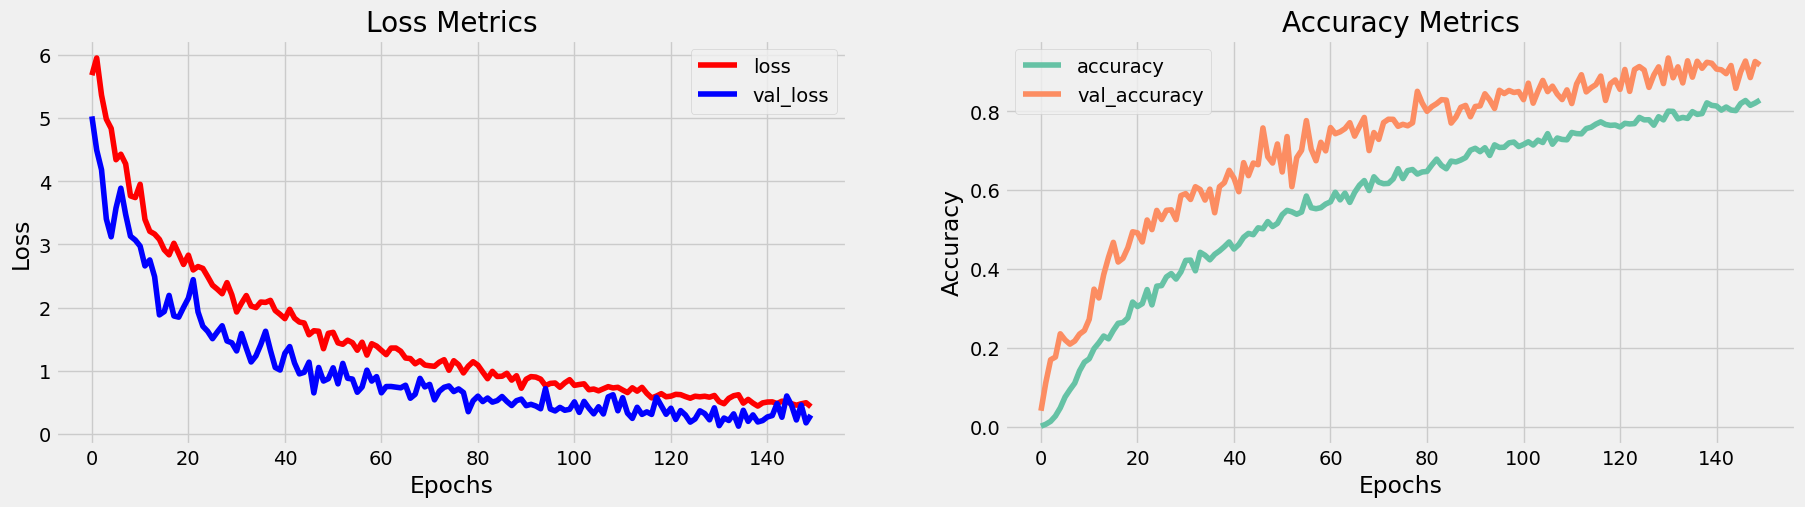

In [47]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
ax[0].plot(history.history['loss'],label='loss',c='red')
ax[0].plot(history.history['val_loss'],label='val_loss',c = 'blue')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[0].set_title('Loss Metrics')
ax[1].set_title('Accuracy Metrics')
ax[1].plot(history.history['accuracy'],label='accuracy')
ax[1].plot(history.history['val_accuracy'],label='val_accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
#model.load_weights('ckpt1')
#model.save('models',save_format='tf')

In [48]:
model.save_weights('my_model_weights.h5')
with open('my_model_config.json', 'w') as f:
    f.write(model.to_json())



In [49]:
for idx,i in enumerate(model.layers):
    print('Encoder layers:' if idx==0 else 'Decoder layers: ')
    for j in i.layers:
        print(j)
    print('---------------------')

Encoder layers:
---------------------
Decoder layers: 
---------------------


In [51]:
class ChatBot(tf.keras.models.Model):
    def __init__(self,base_encoder,base_decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder,self.decoder=self.build_inference_model(base_encoder,base_decoder)

    def build_inference_model(self,base_encoder,base_decoder):
        encoder_inputs=tf.keras.Input(shape=(None,))
        x=base_encoder.layers[0](encoder_inputs)
        x=base_encoder.layers[1](x)
        x,encoder_state_h,encoder_state_c=base_encoder.layers[2](x)
        encoder=tf.keras.models.Model(inputs=encoder_inputs,outputs=[encoder_state_h,encoder_state_c],name='chatbot_encoder')

        decoder_input_state_h=tf.keras.Input(shape=(lstm_cells,))
        decoder_input_state_c=tf.keras.Input(shape=(lstm_cells,))
        decoder_inputs=tf.keras.Input(shape=(None,))
        x=base_decoder.layers[0](decoder_inputs)
        x=base_encoder.layers[1](x)
        x,decoder_state_h,decoder_state_c=base_decoder.layers[2](x,initial_state=[decoder_input_state_h,decoder_input_state_c])
        decoder_outputs=base_decoder.layers[-1](x)
        decoder=tf.keras.models.Model(
            inputs=[decoder_inputs,[decoder_input_state_h,decoder_input_state_c]],
            outputs=[decoder_outputs,[decoder_state_h,decoder_state_c]],name='chatbot_decoder'
        )
        return encoder,decoder

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()

    def softmax(self,z):
        return np.exp(z)/sum(np.exp(z))

    def sample(self,conditional_probability,temperature=0.5):
        conditional_probability = np.asarray(conditional_probability).astype("float64")
        conditional_probability = np.log(conditional_probability) / temperature
        reweighted_conditional_probability = self.softmax(conditional_probability)
        probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
        return np.argmax(probas)

    def preprocess(self,text):
        text=clean_text(text)
        seq=np.zeros((1,max_sequence_length),dtype=np.int32)
        for i,word in enumerate(text.split()):
            seq[:,i]=sequences2ids(word).numpy()[0]
        return seq
    
    def postprocess(self,text):
        text=re.sub(' - ','-',text.lower())
        text=re.sub(' [.] ','. ',text)
        text=re.sub(' [1] ','1',text)
        text=re.sub(' [2] ','2',text)
        text=re.sub(' [3] ','3',text)
        text=re.sub(' [4] ','4',text)
        text=re.sub(' [5] ','5',text)
        text=re.sub(' [6] ','6',text)
        text=re.sub(' [7] ','7',text)
        text=re.sub(' [8] ','8',text)
        text=re.sub(' [9] ','9',text)
        text=re.sub(' [0] ','0',text)
        text=re.sub(' [,] ',', ',text)
        text=re.sub(' [?] ','? ',text)
        text=re.sub(' [!] ','! ',text)
        text=re.sub(' [$] ','$ ',text)
        text=re.sub(' [&] ','& ',text)
        text=re.sub(' [/] ','/ ',text)
        text=re.sub(' [:] ',': ',text)
        text=re.sub(' [;] ','; ',text)
        text=re.sub(' [*] ','* ',text)
        text=re.sub(' [\'] ','\'',text)
        text=re.sub(' [\"] ','\"',text)
        return text

    def call(self,text,config=None):
        input_seq=self.preprocess(text)
        states=self.encoder(input_seq,training=False)
        target_seq=np.zeros((1,1))
        target_seq[:,:]=sequences2ids(['<start>']).numpy()[0][0]
        stop_condition=False
        decoded=[]
        while not stop_condition:
            decoder_outputs,new_states=self.decoder([target_seq,states],training=False)
#             index=tf.argmax(decoder_outputs[:,-1,:],axis=-1).numpy().item()
            index=self.sample(decoder_outputs[0,0,:]).item()
            word=ids2sequences([index])
            if word=='<end> ' or len(decoded)>=max_sequence_length:
                stop_condition=True
            else:
                decoded.append(index)
                target_seq=np.zeros((1,1))
                target_seq[:,:]=index
                states=new_states
        return self.postprocess(ids2sequences(decoded))

chatbot=ChatBot(model.encoder,model.decoder,name='chatbot')
chatbot.summary()

Model: "chatbot_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 encoder_embedding (Embeddin  (None, None, 256)        260096    
 g)                                                              
                                                                 
 layer_normalization_3 (Laye  (None, None, 256)        512       
 rNormalization)                                                 
                                                                 
 encoder_lstm (LSTM)         [(None, None, 256),       525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 785,920
Trainable params: 785,920
Non

In [ ]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Nuwanga Wijamuni\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [ ]:
tf.keras.utils.plot_model(chatbot.encoder,to_file='encoder.png',show_shapes=True,show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
tf.keras.utils.plot_model(chatbot.decoder,to_file='decoder.png',show_shapes=True,show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [52]:
def print_conversation(texts):
    for text in texts:
        print(f'Patient: {text}')
        print(f'DocBot: {chatbot(text)}')
        print('========================')

In [53]:
print_conversation([
    'Hellow Doctor',
    '''I haven't noticed any significant swelling''',
    ''' I'm just a bit concerned about the severity of the reaction'''

])

Patient: Hellow Doctor
DocBot: hello, how can i assist you today? 
Patient: I haven't noticed any significant swelling
DocBot: i understand your concern. it's possible that you're experiencing such a severe allergic reaction, such as anaphylaxis. i'll note that you had any previous reactions after consuming certain foods, including 
Patient:  I'm just a bit concerned about the severity of the reaction
DocBot: i can see some redness and swelling on your neck, and your eyes do appear a bit puffy. i'll need to confirm the diagnosis, i'll need to conduct a physical examination, it 


In [ ]:
class RealTimeChatBot(tf.keras.models.Model):
    def __init__(self,base_encoder,base_decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder,self.decoder=self.build_inference_model(base_encoder,base_decoder)

    def build_inference_model(self,base_encoder,base_decoder):
        encoder_inputs=tf.keras.Input(shape=(None,))
        x=base_encoder.layers[0](encoder_inputs)
        x=base_encoder.layers[1](x)
        x,encoder_state_h,encoder_state_c=base_encoder.layers[2](x)
        encoder=tf.keras.models.Model(inputs=encoder_inputs,outputs=[encoder_state_h,encoder_state_c],name='chatbot_encoder')

        decoder_input_state_h=tf.keras.Input(shape=(lstm_cells,))
        decoder_input_state_c=tf.keras.Input(shape=(lstm_cells,))
        decoder_inputs=tf.keras.Input(shape=(None,))
        x=base_decoder.layers[0](decoder_inputs)
        x=base_encoder.layers[1](x)
        x,decoder_state_h,decoder_state_c=base_decoder.layers[2](x,initial_state=[decoder_input_state_h,decoder_input_state_c])
        decoder_outputs=base_decoder.layers[-1](x)
        decoder=tf.keras.models.Model(
            inputs=[decoder_inputs,[decoder_input_state_h,decoder_input_state_c]],
            outputs=[decoder_outputs,[decoder_state_h,decoder_state_c]],name='chatbot_decoder'
        )
        return encoder,decoder

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()

    def softmax(self,z):
        return np.exp(z)/sum(np.exp(z))

    def sample(self,conditional_probability,temperature=0.5):
        conditional_probability = np.asarray(conditional_probability).astype("float64")
        conditional_probability = np.log(conditional_probability) / temperature
        reweighted_conditional_probability = self.softmax(conditional_probability)
        probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
        return np.argmax(probas)

    def preprocess(self,text):
        text=clean_text(text)
        seq=np.zeros((1,max_sequence_length),dtype=np.int32)
        for i,word in enumerate(text.split()):
            seq[:,i]=sequences2ids(word).numpy()[0]
        return seq
    
    def postprocess(self,text):
        text=re.sub(' - ','-',text.lower())
        text=re.sub(' [.] ','. ',text)
        text=re.sub(' [1] ','1',text)
        text=re.sub(' [2] ','2',text)
        text=re.sub(' [3] ','3',text)
        text=re.sub(' [4] ','4',text)
        text=re.sub(' [5] ','5',text)
        text=re.sub(' [6] ','6',text)
        text=re.sub(' [7] ','7',text)
        text=re.sub(' [8] ','8',text)
        text=re.sub(' [9] ','9',text)
        text=re.sub(' [0] ','0',text)
        text=re.sub(' [,] ',', ',text)
        text=re.sub(' [?] ','? ',text)
        text=re.sub(' [!] ','! ',text)
        text=re.sub(' [$] ','$ ',text)
        text=re.sub(' [&] ','& ',text)
        text=re.sub(' [/] ','/ ',text)
        text=re.sub(' [:] ',': ',text)
        text=re.sub(' [;] ','; ',text)
        text=re.sub(' [*] ','* ',text)
        text=re.sub(' [\'] ','\'',text)
        text=re.sub(' [\"] ','\"',text)
        return text

    def call(self,text,config=None):
        input_seq=self.preprocess(text)
        states=self.encoder(input_seq,training=False)
        target_seq=np.zeros((1,1))
        target_seq[:,:]=sequences2ids(['<start>']).numpy()[0][0]
        stop_condition=False
        decoded=[]
        while not stop_condition:
            decoder_outputs,new_states=self.decoder([target_seq,states],training=False)
#             index=tf.argmax(decoder_outputs[:,-1,:],axis=-1).numpy().item()
            index=self.sample(decoder_outputs[0,0,:]).item()
            word=ids2sequences([index])
            if word=='<end> ' or len(decoded)>=max_sequence_length:
                stop_condition=True
            else:
                decoded.append(index)
                target_seq=np.zeros((1,1))
                target_seq[:,:]=index
                states=new_states
        return self.postprocess(ids2sequences(decoded))

    def chat(self):
        print("Bot: Hello! How can I assist you today?")
        while True:
            user_input = input('User: ')
            if user_input.lower() in ['quit', 'exit', 'bye']:
                print('Bot: Goodbye! Take care.')
                break
            response = self.call(user_input)
            print(f'Bot: {response}')

# Initialize and summarize chatbot
chatbot=RealTimeChatBot(model.encoder,model.decoder,name='chatbot')
chatbot.summary()

# Start a real-time chat with the chatbot
chatbot.chat()


Model: "chatbot_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 encoder_embedding (Embeddin  (None, None, 256)        260096    
 g)                                                              
                                                                 
 layer_normalization (LayerN  (None, None, 256)        512       
 ormalization)                                                   
                                                                 
 encoder_lstm (LSTM)         [(None, None, 256),       525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 785,920
Trainable params: 785,920
Non

In [33]:
from flask import Flask, request, jsonify
from flask_cors import CORS
import tensorflow as tf
import numpy as np
import re

In [57]:
from tensorflow.keras.models import load_model

# Construct the model's architecture
encoder = Encoder(lstm_cells, embedding_dim, vocab_size, name='encoder')
decoder = Decoder(lstm_cells, embedding_dim, vocab_size, name='decoder')
chatbot_trainer = ChatBotTrainer(encoder, decoder)

# Create dummy data
dummy_encoder_input = tf.random.uniform((1, 10), dtype=tf.int32, maxval=vocab_size)
dummy_decoder_input = tf.random.uniform((1, 10), dtype=tf.int32, maxval=vocab_size)

# Call the model on dummy data to initialize its variables
chatbot_trainer([dummy_encoder_input, dummy_decoder_input])

# Now load the weights into the model
chatbot_trainer.load_weights('my_model_weights.h5')




In [59]:
app = Flask(__name__)

# Load your model, tokenizer, and other related objects as needed
# You can use the steps you previously did to load your model here

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    encoder_input = data.get('encoder_input', [])
    decoder_input = data.get('decoder_input', [])
    
    # Convert the input data into the appropriate format for the model
    # Assuming they are in string format and need conversion
    encoder_input = tf.convert_to_tensor(encoder_input, dtype=tf.int32)
    decoder_input = tf.convert_to_tensor(decoder_input, dtype=tf.int32)
    
    # Get the prediction from the model
    prediction = chatbot_trainer([encoder_input, decoder_input])
    predicted_id = tf.argmax(prediction[0], axis=-1).numpy().tolist()
    
    # Convert the prediction to a format you need (e.g., string)
    # and return the response
    response = {
        'prediction': predicted_id
    }

    return jsonify(response)

if __name__ == '__main__':
    app.run(debug=True, use_reloader=False)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [02/Sep/2023 08:37:18] "GET / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [02/Sep/2023 08:37:24] "GET / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [02/Sep/2023 08:37:30] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [02/Sep/2023 08:38:34] "GET / HTTP/1.1" 404 -


In [37]:
custom_objects = {'Encoder': Encoder, 'Decoder': Decoder, 'ChatBotTrainer': ChatBotTrainer}
loaded_model = tf.keras.models.model_from_json(loaded_model_json, custom_objects=custom_objects)
loaded_model.load_weights('my_model_weights.h5')

# Assuming you have a class or method called RealTimeChatBot to generate responses
chatbot = RealTimeChatBot(loaded_model.encoder, loaded_model.decoder, name='chatbot')


TypeError: Unable to revive model from config. When overriding the `get_config()`, make sure that the returned config contains all items used as arguments in the constructor to <class '__main__.Encoder'>, which is the default behavior. You can override this default behavior by defining a `from_config` method to specify how to create an instance of Encoder from the config. 

Error encountered during deserialization:
Encoder.__init__() missing 3 required positional arguments: 'units', 'embedding_dim', and 'vocab_size'